<img src="../../../../images/qiskit_header.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

# _*Quantum-enhanced classification*_

<br>

***
<br>

### Author
Steve Jeffrey<sup></sup>

<i>stephen_j_jeffrey@yahoo.com.au</i>
$$
   \newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
   \newcommand{\ket}[1]{\left|{#1}\right\rangle}
   \newcommand{\bra}[1]{\left\langle{#1}\right|}
   \newcommand{\rpm}{\raisebox{.2ex}{$\scriptstyle\pm$}}
$$

In [1]:
%%javascript
// This enables line numbers in LaTeX equations
// Please note, you may need to enter and exit edit mode in the mark down 
// cells for the equation numbers to display correctly
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

This notebook provides a detailed introduction to a quantum-enhanced method for data classification, using the algorithm, notation and datasets presented in Havlicek *et al* (2019)<sup>[1]</sup>.

For a high level overview of these methods and the implementation using [Aqua](https://qiskit.org/documentation/the_elements.html#aqua), please see the Q Experience [tutorial](https://qiskit.org/documentation/tutorials/machine_learning/01_qsvm_classification.html) and community notebooks:
1. [Variational classifier](https://github.com/Qiskit/qiskit-community-tutorials/blob/master/machine_learning/vqc.ipynb)   
2. [Kernel estimator](https://github.com/Qiskit/qiskit-community-tutorials/blob/master/machine_learning/qsvm.ipynb).

<!-- Link was: https://quantum-computing.ibm.com/jupyter/tutorial/advanced/aqua/machine_learning/qsvm_classification.ipynb -->

In this notebook we augment a classical Support Vector Machine (SVM) with a quantum algorithm for computing the kernel matrix. Havlicek *et al* (2019) also present a quantum variational method for the same classification task, however that method is not demonstrated in this tutorial.

This tutorial also shows how:
 - classical input data can be mapped to quantum states
 - symbolic programming can be used to parameterise circuits
 - a large number of circuits can be efficiently transpiled.

### Introduction to Support Vector Machines
Support Vector Machines are powerful machine learning methods for regression and classification. While SVMs can be used for multi-class classification using a simple one-versus-rest approach, we will focus on the binary classification problem. In this tutorial we will follow the exposition in Burges (1998).

Given a set of $d$-dimensional samples labelled as either 1 or -1:

\begin{equation*}
\{\mathbf{x}_i, y_i\},  i=1, \ldots, l,\; y_i = \{-1, 1\},\; \mathbf{x}_i \in \mathbb{R}^d,
\end{equation*}

we seek the hyperplane which will separate the "positive" ($y=1$) and negative ($y=-1$) samples.

If the samples are linearly separable, we have:
\begin{eqnarray}
\label{lin_sep_row1}
\mathbf{x}_i \cdot \mathbf{w} + b &\ge& +1 \;\;\; \textrm{for}\; y_i = +1\\
\label{lin_sep_row2}
\mathbf{x}_i \cdot \mathbf{w} + b &\le& -1 \;\;\; \textrm{for}\; y_i = -1
\end{eqnarray}

where $\mathbf{w}$ is the normal to the separating hyperplane, and $b/\!\!\parallel\!\!\mathbf{w}\parallel$ is the perpendicular distance from the origin to the hyperplane. We can combine Equations \ref{lin_sep_row1} and \ref{lin_sep_row2} as follows:
\begin{equation}
y_i \left(\mathbf{x}_i \cdot \mathbf{w} + b\right) - 1 \ge 0 \;\;\forall \; i.
\end{equation}

The samples which lie closest to the separating plane are known as *support vectors* and are a perpendicular distance $1/\!\!\parallel\!\!\mathbf{w}\parallel$ from the plane. To find the plane which maximally separates the samples (and therefore most likely to generalize well), we seek the separating plane of maximum *margin* by finding $\mathbf{w}$ with minimal $\parallel\mathbf{w}\parallel$. We can solve the minimization problem by switching to a Lagrangian formulation:
\begin{equation}
\label{lin_sep_lp}
L_P = \frac{1}{2} \parallel\!\!\mathbf{w}\!\!\parallel^2 - 
\sum_{i=1}^{l} \alpha_i y_i \left(\mathbf{x}_i \cdot \mathbf{w} + b\right) + 
\sum_{i=1}^{l} \alpha_i
\end{equation}
where $\alpha_i, i=1,\ldots,l$ are Lagrangian multipliers of the form $\alpha_i \ge 0$. 
The optimal solution is found by minimizing $L_P$ *i.e.* where the derivatives of $L_P$ with respect to $\mathbf{w}$, $b$ and $\alpha_i$ vanish, subject to the constraint $\alpha_i \ge 0 \; \forall \; i$. Given the $\alpha_i$, we can obtain $b$ from the Karush-Kuhn-Tucker conditions. The normal $\parallel\mathbf{w}\parallel$ is then given by:
\begin{equation}
\label{w_sum}
\mathbf{w} = \sum_i \alpha_i y_i \mathbf{x}_i
\end{equation}
and (unseen) test data can then be classified (using Equations \ref{lin_sep_row1} and \ref{lin_sep_row2}). We note the Lagrange multipliers $\alpha_i$ are non-zero for those $\mathbf{x}_i$ which are support vectors, and zero otherwise, so the classification is reduced to a sum over the support vectors $\mathbf{s}_i$:
\begin{equation}
\label{w_sum_v2}
f(\mathbf{x}) = \sum_{i=1}^{N_s} \alpha_i y_i \mathbf{s}_i \cdot\mathbf{x} + b
\end{equation}
where $N_s$ is the number of support vectors.

**Kernel method**

We can convert the *primal* formulation in Equation \ref{lin_sep_lp} to the *dual* formulation (see Burges, 1998):
\begin{equation}
\label{lin_sep_ld}
L_D = \sum_{i=1}^{l} \alpha_i - 
\frac{1}{2} \sum_{i, j=1}^{l} \alpha_i \alpha_j \: y_i y_j \: \mathbf{x}_i \cdot \mathbf{x}_j.
\end{equation}
In this case the optimal solution is found by maximizing $L_D$. The dual formulation is useful because the training data (the $\mathbf{x}_i$) only appear in the form of dot products ($\mathbf{x}_i \cdot \mathbf{x}_j$), a feature which will be very useful, as we will soon see.

<br>
In the preceding discussion we assumed the training data were linearly separable. If the data are not linearly separable, we can add *slack* variables that enable an optimal solution to be found, but still using linear separation function. For further details see (see Burges, 1998. An alternative approach is to map the data:
\begin{equation}
\label{svm_map}
\Phi: \mathbb{R}^d \mapsto \mathcal{H}
\end{equation}

from the original space ($\mathbb{R}^d$) into a higher dimensional space $\mathcal{H}$ and fit the separating function in $\mathcal{H}$. In the dual formulation the data only appear in dot products (see Eqn \ref{lin_sep_ld}), or in the higher dimensional space:
\begin{equation}
\label{svm_map_dp}
\Phi(\mathbf{x}_i) \cdot \Phi(\mathbf{x}_j).
\end{equation}

In practice the mapping $\Phi$ may be difficult to compute or even unknown. If we have access to a *kernel* function $K$:

\begin{equation}
\label{kernel_func}
K(\Phi(\mathbf{x}_i, \mathbf{x}_j) = \Phi(\mathbf{x}_i) \cdot \Phi(\mathbf{x}_j)
\end{equation}

we don't need to explicitly know what $\Phi$ is. Once the optimal separating function has been found, the data can be classified in a manner analagous to the linearly separable case (Equation \ref{w_sum_v2}): 
\begin{eqnarray}
\label{w_sum_kernel}
f(\mathbf{x}) &=& \sum_{i=1}^{N_s} \alpha_i y_i \Phi(\mathbf{s}_i) \cdot \Phi(\mathbf{x}) + b \\
&=& \sum_{i=1}^{N_s} \alpha_i y_i K(\mathbf{s}_i, \mathbf{x}) + b.
\end{eqnarray}

We will use this method in our quantum implementation below.

<br>
References:

[1] Vojtech Havlicek, Antonio D. C´orcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, and Jay M. Gambetta1, "Supervised learning with quantum enhanced feature spaces," Nature **567**, 209–212 (2019), https://doi.org/10.1038/s41586-019-0980-2. An online copy is available [here](https://arxiv.org/pdf/1804.11326.pdf).

[2] Christopher J. Burges. "A tutorial on support vector machines for pattern recognition", Data mining and knowledge discovery **2**, 121–167 (1998).

In [2]:
#from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

"""
   Code copied from: qiskit/aqua/utils/dataset_helper.py
"""

import operator
#from copy import deepcopy
from sklearn.decomposition import PCA

def split_dataset_to_data_and_labels(dataset, class_names=None):
    """
    Split dataset to data and labels numpy array

    If `class_names` is given, use the desired label to class name mapping,
    or create the mapping based on the keys in the dataset.

    Args:
        dataset (dict): {'A': numpy.ndarray, 'B': numpy.ndarray, ...}
        class_names (dict): class name of dataset, {class_name: label}

    Returns:
        Union(tuple(list, dict), list):
            List contains two arrays of numpy.ndarray type
            where the array at index 0 is data, an NxD array, and at
            index 1 it is labels, an Nx1 array, containing values in range
            0 to K-1, where K is the number of classes. The dict is a map
            {str: int}, mapping class name to label. The tuple of list, dict is returned
            when `class_names` is not None, otherwise just the list is returned.

    Raises:
        KeyError: data set invalid
    """
    data = []
    labels = []
    if class_names is None:
        sorted_classes_name = sorted(list(dataset.keys()))
        class_to_label = {k: idx for idx, k in enumerate(sorted_classes_name)}
    else:
        class_to_label = class_names
    sorted_label = sorted(class_to_label.items(), key=operator.itemgetter(1))
    for class_name, _ in sorted_label:
        values = dataset[class_name]
        for value in values:
            data.append(value)
            try:
                labels.append(class_to_label[class_name])
            except Exception as ex:  # pylint: disable=broad-except
                raise KeyError('The dataset has different class names to '
                               'the training data. error message: {}'.format(ex))
    data = np.asarray(data)
    labels = np.asarray(labels)
    if class_names is None:
        return [data, labels], class_to_label
    else:
        return [data, labels]


def map_label_to_class_name(predicted_labels, label_to_class):
    """
    Helper converts labels (numeric) to class name (string)

    Args:
        predicted_labels (numpy.ndarray): Nx1 array
        label_to_class (dict or list): a mapping form label (numeric) to class name (str)

    Returns:
        str: predicted class names of each datum
    """

    if not isinstance(predicted_labels, np.ndarray):
        predicted_labels = np.asarray([predicted_labels])

    predicted_class_names = []

    for predicted_label in predicted_labels:
        predicted_class_names.append(label_to_class[predicted_label])
    return predicted_class_names

In [3]:
#from qiskit.ml.datasets.ad_hoc import * 
"""
   Code copied from: qiskit/ml/datasets/ad_hoc.py
"""

import numpy as np
import scipy
from qiskit.aqua import aqua_globals


def ad_hoc_data(training_size, test_size, n, gap, plot_data=False):
    """ returns ad hoc dataset """
    class_labels = [r'A', r'B']
    count = 0
    if n == 2:
        count = 100
    elif n == 3:
        count = 20   # coarseness of data separation

    label_train = np.zeros(2 * (training_size + test_size))
    sample_train = []
    sample_a = [[0 for x in range(n)] for y in range(training_size + test_size)]
    sample_b = [[0 for x in range(n)] for y in range(training_size + test_size)]

    sample_total = [[[0 for x in range(count)] for y in range(count)] for z in range(count)]

    # interactions = np.transpose(np.array([[1, 0], [0, 1], [1, 1]]))

    steps = 2 * np.pi / count

    # sx = np.array([[0, 1], [1, 0]])
    # X = np.asmatrix(sx)
    # sy = np.array([[0, -1j], [1j, 0]])
    # Y = np.asmatrix(sy)
    s_z = np.array([[1, 0], [0, -1]])
    z_m = np.asmatrix(s_z)
    j_m = np.array([[1, 0], [0, 1]])
    j_m = np.asmatrix(j_m)
    h_m = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    h_2 = np.kron(h_m, h_m)
    h_3 = np.kron(h_m, h_2)
    h_m = np.asmatrix(h_m)
    h_2 = np.asmatrix(h_2)
    h_3 = np.asmatrix(h_3)

    f_a = np.arange(2**n)

    my_array = [[0 for x in range(n)] for y in range(2 ** n)]

    for arindex, _ in enumerate(my_array):
        temp_f = bin(f_a[arindex])[2:].zfill(n)
        for findex in range(n):
            my_array[arindex][findex] = int(temp_f[findex])

    my_array = np.asarray(my_array)
    my_array = np.transpose(my_array)

    # Define decision functions
    maj = (-1) ** (2 * my_array.sum(axis=0) > n)
    parity = (-1) ** (my_array.sum(axis=0))
    # dict1 = (-1) ** (my_array[0])
    d_m = None
    if n == 2:
        d_m = np.diag(parity)
    elif n == 3:
        d_m = np.diag(maj)

    basis = aqua_globals.random.random((2 ** n, 2 ** n)) + \
        1j * aqua_globals.random.random((2 ** n, 2 ** n))
    basis = np.asmatrix(basis).getH() * np.asmatrix(basis)

    [s_a, u_a] = np.linalg.eig(basis)

    idx = s_a.argsort()[::-1]
    s_a = s_a[idx]
    u_a = u_a[:, idx]

    m_m = (np.asmatrix(u_a)).getH() * np.asmatrix(d_m) * np.asmatrix(u_a)

    psi_plus = np.transpose(np.ones(2)) / np.sqrt(2)
    psi_0 = 1
    for k in range(n):
        psi_0 = np.kron(np.asmatrix(psi_0), np.asmatrix(psi_plus))

    sample_total_a = []
    sample_total_b = []
    sample_total_void = []
    if n == 2:
        for n_1 in range(count):
            for n_2 in range(count):
                x_1 = steps * n_1
                x_2 = steps * n_2
                phi = x_1 * np.kron(z_m, j_m) + x_2 * np.kron(j_m, z_m) + \
                    (np.pi - x_1) * (np.pi - x_2) * np.kron(z_m, z_m)
                u_u = scipy.linalg.expm(1j * phi)  # pylint: disable=no-member
                psi = np.asmatrix(u_u) * h_2 * np.asmatrix(u_u) * np.transpose(psi_0)
                temp = np.real(psi.getH() * m_m * psi).item()
                if temp > gap:
                    sample_total[n_1][n_2] = +1
                elif temp < -gap:
                    sample_total[n_1][n_2] = -1
                else:
                    sample_total[n_1][n_2] = 0

        # Now sample randomly from sample_Total a number of times training_size+testing_size
        t_r = 0
        while t_r < (training_size + test_size):
            draw1 = aqua_globals.random.choice(count)
            draw2 = aqua_globals.random.choice(count)
            if sample_total[draw1][draw2] == +1:
                sample_a[t_r] = [2 * np.pi * draw1 / count, 2 * np.pi * draw2 / count]
                t_r += 1

        t_r = 0
        while t_r < (training_size + test_size):
            draw1 = aqua_globals.random.choice(count)
            draw2 = aqua_globals.random.choice(count)
            if sample_total[draw1][draw2] == -1:
                sample_b[t_r] = [2 * np.pi * draw1 / count, 2 * np.pi * draw2 / count]
                t_r += 1

        sample_train = [sample_a, sample_b]

        for lindex in range(training_size + test_size):
            label_train[lindex] = 0
        for lindex in range(training_size + test_size):
            label_train[training_size + test_size + lindex] = 1
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (2 * (training_size + test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size + test_size)] for k, key in enumerate(class_labels)}

        if plot_data:
            try:
                import matplotlib.pyplot as plt
            except ImportError:
                raise NameError('Matplotlib not installed. Please install it before plotting')

            # This part taken from an earlier version            
            img = plt.imshow(np.asmatrix(sample_total).T, interpolation='nearest',
                             origin='lower', cmap='copper', extent=[0, 2*np.pi, 0, 2*np.pi])
            plt.show()
            fig2 = plt.figure()
            for k in range(0, 2):
                plt.scatter(sample_train[label_train == k, 0][:training_size],
                            sample_train[label_train == k, 1][:training_size])

            plt.title("Ad-hoc Data")
            plt.show()

    elif n == 3:
        for n_1 in range(count):
            for n_2 in range(count):
                for n_3 in range(count):
                    x_1 = steps * n_1
                    x_2 = steps * n_2
                    x_3 = steps * n_3
                    phi = x_1 * np.kron(np.kron(z_m, j_m), j_m) + \
                        x_2 * np.kron(np.kron(j_m, z_m), j_m) + \
                        x_3 * np.kron(np.kron(j_m, j_m), z_m) + \
                        (np.pi - x_1) * (np.pi - x_2) * np.kron(np.kron(z_m, z_m), j_m) + \
                        (np.pi - x_2) * (np.pi - x_3) * np.kron(np.kron(j_m, z_m), z_m) + \
                        (np.pi - x_1) * (np.pi - x_3) * np.kron(np.kron(z_m, j_m), z_m)
                    u_u = scipy.linalg.expm(1j * phi)  # pylint: disable=no-member
                    psi = np.asmatrix(u_u) * h_3 * np.asmatrix(u_u) * np.transpose(psi_0)
                    temp = np.real(psi.getH() * m_m * psi).item()
                    if temp > gap:
                        sample_total[n_1][n_2][n_3] = +1
                        sample_total_a.append([n_1, n_2, n_3])
                    elif temp < -gap:
                        sample_total[n_1][n_2][n_3] = -1
                        sample_total_b.append([n_1, n_2, n_3])
                    else:
                        sample_total[n_1][n_2][n_3] = 0
                        sample_total_void.append([n_1, n_2, n_3])

        # Now sample randomly from sample_Total a number of times training_size+testing_size
        t_r = 0
        while t_r < (training_size + test_size):
            draw1 = aqua_globals.random.choice(count)
            draw2 = aqua_globals.random.choice(count)
            draw3 = aqua_globals.random.choice(count)
            if sample_total[draw1][draw2][draw3] == +1:
                sample_a[t_r] = [2 * np.pi * draw1 / count,
                                 2 * np.pi * draw2 / count, 2 * np.pi * draw3 / count]
                t_r += 1

        t_r = 0
        while t_r < (training_size + test_size):
            draw1 = aqua_globals.random.choice(count)
            draw2 = aqua_globals.random.choice(count)
            draw3 = aqua_globals.random.choice(count)
            if sample_total[draw1][draw2][draw3] == -1:
                sample_b[t_r] = [2 * np.pi * draw1 / count,
                                 2 * np.pi * draw2 / count, 2 * np.pi * draw3 / count]
                t_r += 1

        sample_train = [sample_a, sample_b]

        for lindex in range(training_size + test_size):
            label_train[lindex] = 0
        for lindex in range(training_size + test_size):
            label_train[training_size + test_size + lindex] = 1
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (2 * (training_size + test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size + test_size)] for k, key in enumerate(class_labels)}

        if plot_data:
            try:
                import matplotlib.pyplot as plt
            except ImportError:
                raise NameError('Matplotlib not installed. Please install it before plotting')
            sample_total_a = np.asarray(sample_total_a)
            sample_total_b = np.asarray(sample_total_b)
            x_1 = sample_total_a[:, 0]
            y_1 = sample_total_a[:, 1]
            z_1 = sample_total_a[:, 2]

            x_2 = sample_total_b[:, 0]
            y_2 = sample_total_b[:, 1]
            z_2 = sample_total_b[:, 2]

            fig1 = plt.figure()
            ax_1 = fig1.add_subplot(1, 1, 1, projection='3d')
            ax_1.scatter(x_1, y_1, z_1, c='#8A360F')
            plt.show()

            fig2 = plt.figure()
            ax_2 = fig2.add_subplot(1, 1, 1, projection='3d')
            ax_2.scatter(x_2, y_2, z_2, c='#683FC8')
            plt.show()

            sample_training_a = training_input['A']
            sample_training_b = training_input['B']

            x_1 = sample_training_a[:, 0]
            y_1 = sample_training_a[:, 1]
            z_1 = sample_training_a[:, 2]

            x_2 = sample_training_b[:, 0]
            y_2 = sample_training_b[:, 1]
            z_2 = sample_training_b[:, 2]

            fig1 = plt.figure()
            ax_1 = fig1.add_subplot(1, 1, 1, projection='3d')
            ax_1.scatter(x_1, y_1, z_1, c='#8A360F')
            ax_1.scatter(x_2, y_2, z_2, c='#683FC8')
            plt.show()

    return sample_total, training_input, test_input, class_labels


def sample_ad_hoc_data(sample_total, test_size, n):
    """ returns sample ad hoc data """

    class_labels = [r'A', r'B']  # copied from ad_hoc_data()
    count = 0
    if n == 2:
        count = 100
    elif n == 3:
        count = 20

    label_train = np.zeros(2 * test_size)
    sample_a = [[0 for x in range(n)] for y in range(test_size)]
    sample_b = [[0 for x in range(n)] for y in range(test_size)]
    t_r = 0
    while t_r < (test_size):
        draw1 = aqua_globals.random.choice(count)
        draw2 = aqua_globals.random.choice(count)
        if sample_total[draw1][draw2] == +1:
            sample_a[t_r] = [2 * np.pi * draw1 / count, 2 * np.pi * draw2 / count]
            t_r += 1

    t_r = 0
    while t_r < (test_size):
        draw1 = aqua_globals.random.choice(count)
        draw2 = aqua_globals.random.choice(count)
        if sample_total[draw1][draw2] == -1:
            sample_b[t_r] = [2 * np.pi * draw1 / count, 2 * np.pi * draw2 / count]
            t_r += 1
    sample_train = [sample_a, sample_b]
    for lindex in range(test_size):
        label_train[lindex] = 0
    for lindex in range(test_size):
        label_train[test_size + lindex] = 1
    label_train = label_train.astype(int)
    sample_train = np.reshape(sample_train, (2 * test_size, n))
    test_input = {key: (sample_train[label_train == k, :])[:] for k, key in enumerate(class_labels)}
    return test_input

In [4]:
"""
   Code copied from: qiskit/aqua/quantum_instance.py
"""
# -*- coding: utf-8 -*-

# This code is part of Qiskit.
#
# (C) Copyright IBM 2018, 2020.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

""" Quantum Instance module """

import copy
import logging
import time

from qiskit.assembler.run_config import RunConfig
from qiskit import compiler

from qiskit.aqua.aqua_error import AquaError
from qiskit.aqua.utils.backend_utils import (is_ibmq_provider,
                                  is_statevector_backend,
                                  is_simulator_backend,
                                  is_local_backend,
                                  is_aer_qasm,
                                  support_backend_options)
from qiskit.aqua.utils.circuit_utils import summarize_circuits

logger = logging.getLogger(__name__)


class QuantumInstance:
    """Quantum Backend including execution setting."""

    BACKEND_CONFIG = ['basis_gates', 'coupling_map']
    COMPILE_CONFIG = ['pass_manager', 'initial_layout', 'seed_transpiler', 'optimization_level']
    RUN_CONFIG = ['shots', 'max_credits', 'memory', 'seed_simulator']
    QJOB_CONFIG = ['timeout', 'wait']
    NOISE_CONFIG = ['noise_model']

    # https://github.com/Qiskit/qiskit-aer/blob/master/qiskit/providers/aer/backends/qasm_simulator.py
    BACKEND_OPTIONS_QASM_ONLY = ["statevector_sample_measure_opt", "max_parallel_shots"]
    BACKEND_OPTIONS = ["initial_statevector", "chop_threshold", "max_parallel_threads",
                       "max_parallel_experiments", "statevector_parallel_threshold",
                       "statevector_hpc_gate_opt"] + BACKEND_OPTIONS_QASM_ONLY

    def __init__(self, backend,
                 # run config
                 shots=1024, seed_simulator=None, max_credits=10,
                 # backend properties
                 basis_gates=None, coupling_map=None,
                 # transpile
                 initial_layout=None, pass_manager=None,
                 seed_transpiler=None, optimization_level=None,
                 # simulation
                 backend_options=None, noise_model=None,
                 # job
                 timeout=None, wait=5,
                 # others
                 skip_qobj_validation=True,
                 measurement_error_mitigation_cls=None, cals_matrix_refresh_period=30,
                 measurement_error_mitigation_shots=None,
                 job_callback=None):
        """
        Quantum Instance holds a Qiskit Terra backend as well as configuration for circuit
        transpilation and execution. When provided to an Aqua algorithm the algorithm will
        execute the circuits it needs to run using the instance.

        Args:
            backend (BaseBackend): Instance of selected backend
            shots (int, optional): Number of repetitions of each circuit, for sampling
            seed_simulator (int, optional): Random seed for simulators
            max_credits (int, optional): Maximum credits to use
            basis_gates (list[str], optional): List of basis gate names supported by the
                                               target. Default: ['u1', 'u2', 'u3', 'cx', 'id']
            coupling_map (CouplingMap or list[list]): Coupling map (perhaps custom) to
                                                      target in mapping
            initial_layout (Layout or dict or list, optional): Initial layout of qubits in mapping
            pass_manager (PassManager, optional): Pass manager to handle how to compile the circuits
            seed_transpiler (int, optional): The random seed for circuit mapper
            optimization_level (int, optional): How much optimization to perform on the circuits.
                Higher levels generate more optimized circuits, at the expense of longer
                transpilation time.
            backend_options (dict, optional): All running options for backend, please refer
                to the provider of the backend for information as to what options it supports.
            noise_model (qiskit.provider.aer.noise.noise_model.NoiseModel, optional): noise model
                                                                                      for simulator
            timeout (float, optional): Seconds to wait for job. If None, wait indefinitely.
            wait (float, optional): Seconds between queries for job result
            skip_qobj_validation (bool, optional): Bypass Qobj validation to decrease circuit
                processing time during submission to backend.
            measurement_error_mitigation_cls (Callable, optional): The approach to mitigate
                measurement errors. Qiskit Ignis provides fitter classes for this functionality
                and CompleteMeasFitter from qiskit.ignis.mitigation.measurement module can be used
                here. (TensoredMeasFitter is not supported).
            cals_matrix_refresh_period (int, optional): How often to refresh the calibration
                matrix in measurement mitigation. in minutes
            measurement_error_mitigation_shots (int, optional): The number of shots number for
                building calibration matrix. If None, the main `shots` parameter value is used.
            job_callback (Callable, optional): Optional user supplied callback which can be used
                to monitor job progress as jobs are submitted for processing by an Aqua algorithm.
                The callback is provided the following arguments: `job_id, job_status,
                queue_position, job`

        Raises:
            AquaError: the shots exceeds the maximum number of shots
            AquaError: set noise model but the backend does not support that
            AquaError: set backend_options but the backend does not support that
        """
        self._backend = backend

        # setup run config
        if shots is not None:
            if self.is_statevector and shots != 1:
                logger.info("statevector backend only works with shot=1, change "
                            "shots from %s to 1.", shots)
                shots = 1
            max_shots = self._backend.configuration().max_shots
            if max_shots is not None and shots > max_shots:
                raise AquaError('the maximum shots supported by the selected backend is {} '
                                'but you specifiy {}'.format(max_shots, shots))

        run_config = RunConfig(shots=shots, max_credits=max_credits)
        if seed_simulator:
            run_config.seed_simulator = seed_simulator

        self._run_config = run_config

        # setup backend config
        basis_gates = basis_gates or backend.configuration().basis_gates
        coupling_map = coupling_map or getattr(backend.configuration(), 'coupling_map', None)
        self._backend_config = {
            'basis_gates': basis_gates,
            'coupling_map': coupling_map
        }

        # setup compile config
        self._compile_config = {
            'pass_manager': pass_manager,
            'initial_layout': initial_layout,
            'seed_transpiler': seed_transpiler,
            'optimization_level': optimization_level
        }

        # setup job config
        self._qjob_config = {'timeout': timeout} if self.is_local \
            else {'timeout': timeout, 'wait': wait}

        # setup noise config
        self._noise_config = {}
        if noise_model is not None:
            if is_aer_qasm(self._backend):
                self._noise_config = {'noise_model': noise_model}
            else:
                raise AquaError("The noise model is not supported on the selected backend {} ({}) "
                                "only certain backends, such as Aer qasm "
                                "support noise.".format(self.backend_name,
                                                        self._backend.provider()))

        # setup backend options for run
        self._backend_options = {}
        if backend_options is not None:
            if support_backend_options(self._backend):
                self._backend_options = {'backend_options': backend_options}
            else:
                raise AquaError("backend_options can not used with the backends in IBMQ provider.")

        # setup measurement error mitigation
        self._meas_error_mitigation_cls = None
        if self.is_statevector:
            if measurement_error_mitigation_cls is not None:
                raise AquaError("Measurement error mitigation does not work "
                                "with the statevector simulation.")
        else:
            self._meas_error_mitigation_cls = measurement_error_mitigation_cls
        self._meas_error_mitigation_fitters = {}
        # TODO: support different fitting method in error mitigation?
        self._meas_error_mitigation_method = 'least_squares'
        self._cals_matrix_refresh_period = cals_matrix_refresh_period
        self._meas_error_mitigation_shots = measurement_error_mitigation_shots

        if self._meas_error_mitigation_cls is not None:
            logger.info("The measurement error mitigation is enable. "
                        "It will automatically submit an additional job to help "
                        "calibrate the result of other jobs. "
                        "The current approach will submit a job with 2^N circuits "
                        "to build the calibration matrix, "
                        "where N is the number of measured qubits. "
                        "Furthermore, Aqua will re-use the calibration matrix for %s minutes "
                        "and re-build it after that.", self._cals_matrix_refresh_period)

        # setup others
        if is_ibmq_provider(self._backend):
            if skip_qobj_validation:
                logger.warning("The skip Qobj validation does not work "
                               "for IBMQ provider. Disable it.")
                skip_qobj_validation = False
        self._skip_qobj_validation = skip_qobj_validation
        self._circuit_summary = False
        self._job_callback = job_callback
        logger.info(self)

    def __str__(self) -> str:
        """Overload string.

        Returns:
            str: the info of the object.
        """
        # pylint: disable=import-outside-toplevel
        from qiskit import __version__ as terra_version

        info = "\nQiskit Terra version: {}\n".format(terra_version)
        info += "Backend: '{} ({})', with following setting:\n{}\n{}\n{}\n{}\n{}\n{}".format(
            self.backend_name, self._backend.provider(), self._backend_config, self._compile_config,
            self._run_config, self._qjob_config, self._backend_options, self._noise_config)
        info += "\nMeasurement mitigation: {}".format(self._meas_error_mitigation_cls)

        return info

    def transpile(self, circuits):
        """
        A wrapper to transpile circuits to allow algorithm access the transpiled circuits.
        Args:
            circuits (QuantumCircuit or list[QuantumCircuit]): circuits to transpile
        Returns:
            list[QuantumCircuit]: the transpiled circuits, it is always a list even though
                                  the length is one.
        """
        transpiled_circuits = compiler.transpile(circuits, self._backend, **self._backend_config,
                                                 **self._compile_config)
        if not isinstance(transpiled_circuits, list):
            transpiled_circuits = [transpiled_circuits]

        if logger.isEnabledFor(logging.DEBUG) and self._circuit_summary:
            logger.debug("==== Before transpiler ====")
            logger.debug(summarize_circuits(circuits))
            if transpiled_circuits is not None:
                logger.debug("====  After transpiler ====")
                logger.debug(summarize_circuits(transpiled_circuits))

        return transpiled_circuits

    def assemble(self, circuits):
        """ assemble circuits """
        return compiler.assemble(circuits, **self._run_config.to_dict())

    def execute(self, circuits, had_transpiled=False):
        """
        A wrapper to interface with quantum backend.

        Args:
            circuits (QuantumCircuit or list[QuantumCircuit]): circuits to execute
            had_transpiled (bool, optional): whether or not circuits had been transpiled

        Returns:
            Result: Result object

        TODO: Maybe we can combine the circuits for the main ones and calibration circuits before
              assembling to the qobj.
        """
        # pylint: disable=import-outside-toplevel
        from qiskit.aqua.utils.run_circuits import run_qobj

        from qiskit.aqua.utils.measurement_error_mitigation import (get_measured_qubits_from_qobj,
                                                         build_measurement_error_mitigation_qobj)
        # maybe compile
        if not had_transpiled:
            circuits = self.transpile(circuits)

        # assemble
        qobj = self.assemble(circuits)

        if self._meas_error_mitigation_cls is not None:
            qubit_index, qubit_mappings = get_measured_qubits_from_qobj(qobj)
            qubit_index_str = '_'.join([str(x) for x in qubit_index]) + \
                "_{}".format(self._meas_error_mitigation_shots or self._run_config.shots)
            meas_error_mitigation_fitter, timestamp = \
                self._meas_error_mitigation_fitters.get(qubit_index_str, (None, 0))

            if meas_error_mitigation_fitter is None:
                # check the asked qubit_index are the subset of build matrices
                for key, _ in self._meas_error_mitigation_fitters.items():
                    stored_qubit_index = [int(x) for x in key.split("_")[:-1]]
                    stored_shots = int(key.split("_")[-1])
                    if len(qubit_index) < len(stored_qubit_index):
                        tmp = list(set(qubit_index + stored_qubit_index))
                        if sorted(tmp) == sorted(stored_qubit_index) and \
                                self._run_config.shots == stored_shots:
                            # the qubit used in current job is the subset and shots are the same
                            meas_error_mitigation_fitter, timestamp = \
                                self._meas_error_mitigation_fitters.get(key, (None, 0))
                            meas_error_mitigation_fitter = \
                                meas_error_mitigation_fitter.subset_fitter(
                                    qubit_sublist=qubit_index)
                            logger.info("The qubits used in the current job is the subset of "
                                        "previous jobs, "
                                        "reusing the calibration matrix if it is not out-of-date.")

            build_cals_matrix = self.maybe_refresh_cals_matrix(timestamp) or \
                meas_error_mitigation_fitter is None

            if build_cals_matrix:
                logger.info("Updating qobj with the circuits for measurement error mitigation.")
                use_different_shots = not (
                    self._meas_error_mitigation_shots is None
                    or self._meas_error_mitigation_shots == self._run_config.shots)
                temp_run_config = copy.deepcopy(self._run_config)
                if use_different_shots:
                    temp_run_config.shots = self._meas_error_mitigation_shots

                cals_qobj, state_labels, circuit_labels = \
                    build_measurement_error_mitigation_qobj(qubit_index,
                                                            self._meas_error_mitigation_cls,
                                                            self._backend,
                                                            self._backend_config,
                                                            self._compile_config,
                                                            temp_run_config)
                if use_different_shots:
                    cals_result = run_qobj(cals_qobj, self._backend, self._qjob_config,
                                           self._backend_options,
                                           self._noise_config,
                                           self._skip_qobj_validation, self._job_callback)
                    result = run_qobj(qobj, self._backend, self._qjob_config,
                                      self._backend_options, self._noise_config,
                                      self._skip_qobj_validation, self._job_callback)
                else:
                    # insert the calibration circuit into main qobj if the shots are the same
                    qobj.experiments[0:0] = cals_qobj.experiments
                    result = run_qobj(qobj, self._backend, self._qjob_config,
                                      self._backend_options, self._noise_config,
                                      self._skip_qobj_validation, self._job_callback)
                    cals_result = result

                logger.info("Building calibration matrix for measurement error mitigation.")
                meas_error_mitigation_fitter = \
                    self._meas_error_mitigation_cls(cals_result,
                                                    state_labels,
                                                    qubit_list=qubit_index,
                                                    circlabel=circuit_labels)
                self._meas_error_mitigation_fitters[qubit_index_str] = \
                    (meas_error_mitigation_fitter, time.time())
            else:
                result = run_qobj(qobj, self._backend, self._qjob_config,
                                  self._backend_options, self._noise_config,
                                  self._skip_qobj_validation, self._job_callback)

            if meas_error_mitigation_fitter is not None:
                logger.info("Performing measurement error mitigation.")
                skip_num_circuits = len(result.results) - len(circuits)
                #  remove the calibration counts from result object to assure the length of
                #  ExperimentalResult is equal length to input circuits
                result.results = result.results[skip_num_circuits:]
                tmp_result = copy.deepcopy(result)
                for qubit_index_str, c_idx in qubit_mappings.items():
                    curr_qubit_index = [int(x) for x in qubit_index_str.split("_")]
                    tmp_result.results = [result.results[i] for i in c_idx]
                    if curr_qubit_index == qubit_index:
                        tmp_fitter = meas_error_mitigation_fitter
                    else:
                        tmp_fitter = meas_error_mitigation_fitter.subset_fitter(curr_qubit_index)
                    tmp_result = tmp_fitter.filter.apply(
                        tmp_result, self._meas_error_mitigation_method
                    )
                    for i, n in enumerate(c_idx):
                        result.results[n] = tmp_result.results[i]

        else:
            result = run_qobj(qobj, self._backend, self._qjob_config,
                              self._backend_options, self._noise_config,
                              self._skip_qobj_validation, self._job_callback)

        if self._circuit_summary:
            self._circuit_summary = False

        return result

    def set_config(self, **kwargs):
        """Set configurations for the quantum instance."""
        for k, v in kwargs.items():
            if k in QuantumInstance.RUN_CONFIG:
                setattr(self._run_config, k, v)
            elif k in QuantumInstance.QJOB_CONFIG:
                self._qjob_config[k] = v
            elif k in QuantumInstance.COMPILE_CONFIG:
                self._compile_config[k] = v
            elif k in QuantumInstance.BACKEND_CONFIG:
                self._backend_config[k] = v
            elif k in QuantumInstance.BACKEND_OPTIONS:
                if not support_backend_options(self._backend):
                    raise AquaError("backend_options can not be used with this backends "
                                    "{} ({}).".format(self.backend_name, self._backend.provider()))

                if k in QuantumInstance.BACKEND_OPTIONS_QASM_ONLY and self.is_statevector:
                    raise AquaError("'{}' is only applicable for qasm simulator but "
                                    "statevector simulator is used as the backend.")

                if 'backend_options' not in self._backend_options:
                    self._backend_options['backend_options'] = {}
                self._backend_options['backend_options'][k] = v
            elif k in QuantumInstance.NOISE_CONFIG:
                if not is_aer_qasm(self._backend):
                    raise AquaError(
                        "The noise model is not supported on the selected backend {} ({}) "
                        "only certain backends, such as Aer qasm support "
                        "noise.".format(self.backend_name, self._backend.provider()))

                self._noise_config[k] = v

            else:
                raise ValueError("unknown setting for the key ({}).".format(k))

    @property
    def qjob_config(self):
        """Getter of qjob_config."""
        return self._qjob_config

    @property
    def backend_config(self):
        """Getter of backend_config."""
        return self._backend_config

    @property
    def compile_config(self):
        """Getter of compile_config."""
        return self._compile_config

    @property
    def run_config(self):
        """Getter of run_config."""
        return self._run_config

    @property
    def noise_config(self):
        """Getter of noise_config."""
        return self._noise_config

    @property
    def backend_options(self):
        """Getter of backend_options."""
        return self._backend_options

    @property
    def circuit_summary(self):
        """Getter of circuit summary."""
        return self._circuit_summary

    @circuit_summary.setter
    def circuit_summary(self, new_value):
        """ sets circuit summary """
        self._circuit_summary = new_value

    @property
    def measurement_error_mitigation_cls(self):  # pylint: disable=invalid-name
        """ returns measurement error mitigation cls """
        return self._meas_error_mitigation_cls

    @measurement_error_mitigation_cls.setter
    def measurement_error_mitigation_cls(self, new_value):  # pylint: disable=invalid-name
        """ sets measurement error mitigation cls """
        self._meas_error_mitigation_cls = new_value

    @property
    def cals_matrix_refresh_period(self):
        """ returns matrix refresh period """
        return self._cals_matrix_refresh_period

    @cals_matrix_refresh_period.setter
    def cals_matrix_refresh_period(self, new_value):
        """ sets matrix refresh period """
        self._cals_matrix_refresh_period = new_value

    @property
    def measurement_error_mitigation_shots(self):  # pylint: disable=invalid-name
        """ returns measurement error mitigation shots """
        return self._meas_error_mitigation_shots

    @measurement_error_mitigation_shots.setter
    def measurement_error_mitigation_shots(self, new_value):  # pylint: disable=invalid-name
        """ sets measurement error mitigation shots """
        self._meas_error_mitigation_shots = new_value

    @property
    def backend(self):
        """Return BaseBackend backend object."""
        return self._backend

    @property
    def backend_name(self):
        """Return backend name."""
        return self._backend.name()

    @property
    def is_statevector(self):
        """Return True if backend is a statevector-type simulator."""
        return is_statevector_backend(self._backend)

    @property
    def is_simulator(self):
        """Return True if backend is a simulator."""
        return is_simulator_backend(self._backend)

    @property
    def is_local(self):
        """Return True if backend is a local backend."""
        return is_local_backend(self._backend)

    @property
    def skip_qobj_validation(self):
        """ checks if skip qobj validation """
        return self._skip_qobj_validation

    @skip_qobj_validation.setter
    def skip_qobj_validation(self, new_value):
        """ sets skip qobj validation flag """
        self._skip_qobj_validation = new_value

    def maybe_refresh_cals_matrix(self, timestamp=None):
        """
        Calculate the time difference from the query of last time.

        Returns:
            bool: whether or not refresh the cals_matrix
        """
        timestamp = timestamp or 0
        ret = False
        curr_timestamp = time.time()
        difference = int(curr_timestamp - timestamp) / 60.0
        if difference > self._cals_matrix_refresh_period:
            ret = True

        return ret

    def cals_matrix(self, qubit_index=None):
        """
        Get the stored calibration matrices and its timestamp.

        Args:
            qubit_index (list[int]): the qubit index of corresponding calibration matrix.
            If None, return all stored calibration matrices.

        Returns:
            tuple(np.ndarray, int): the calibration matrix and the creation timestamp if qubit_index
                                    is not None otherwise, return all matrices and their timestamp
                                    in a dictionary.
        """
        ret = None
        shots = self._meas_error_mitigation_shots or self._run_config.shots
        if qubit_index:
            qubit_index_str = '_'.join([str(x) for x in qubit_index]) + "_{}".format(shots)
            fitter, timestamp = self._meas_error_mitigation_fitters.get(qubit_index_str, None)
            if fitter is not None:
                ret = (fitter.cal_matrix, timestamp)
        else:
            ret = {k: (v.cal_matrix, t) for k, (v, t)
                   in self._meas_error_mitigation_fitters.items()}
        return ret

In [5]:
"""
Code copied from: qiskit/aqua/algorithms/many_sample/qsvm/_qsvm_abc.py
"""

"""Abstract base class for the binary classifier and the multiclass classifier."""

from abc import ABC, abstractmethod

# pylint: disable=invalid-name


class _QSVM_ABC(ABC):
    """Abstract base class for the binary classifier and the multiclass classifier."""

    def __init__(self, qalgo):

        self._qalgo = qalgo
        self._ret = {}

    @abstractmethod
    def run(self):
        """ run """
        raise NotImplementedError("Must have implemented this.")

    @property
    def ret(self):
        """ return result """
        return self._ret

    @ret.setter
    def ret(self, new_ret):
        """ sets result """
        self._ret = new_ret


In [6]:
"""
Code copied from: qiskit/aqua/algorithms/many_sample/qsvm/_qsvm_binary.py
"""

"""The binary classifier."""

import logging
import warnings

import numpy as np

from qiskit.aqua.utils import map_label_to_class_name, optimize_svm
from qiskit.aqua.algorithms.classifiers.qsvm._qsvm_abc import _QSVM_ABC

logger = logging.getLogger(__name__)

# pylint: disable=invalid-name


class _QSVM_Binary(_QSVM_ABC):
    """The binary classifier."""

    def construct_circuit(self, x1, x2, measurement=False):
        """ construct circuit """
        warnings.warn("Please use the 'construct_circuit' in the qsvm class directly.",
                      DeprecationWarning)
        return self._qalgo.construct_circuit(x1, x2, measurement)

    def construct_kernel_matrix(self, x1_vec, x2_vec=None):
        """ construct kernel matrix """
        warnings.warn("Please use the 'construct_kernel_matrix' in the qsvm "
                      "class directly.", DeprecationWarning)
        return self._qalgo.construct_kernel_matrix(x1_vec, x2_vec, self._qalgo.quantum_instance)

    def get_predicted_confidence(self, data, return_kernel_matrix=False):
        """Get predicted confidence.

        Args:
            data (numpy.ndarray): NxD array, where N is the number of data,
                                  D is the feature dimension.
            return_kernel_matrix (bool): return kernel matrix
        Returns:
            numpy.ndarray: Nx1 array, predicted confidence
            numpy.ndarray (optional): the kernel matrix, NxN1, where N1 is
                                      the number of support vectors.
        """
        alphas = self._ret['svm']['alphas']
        bias = self._ret['svm']['bias']
        svms = self._ret['svm']['support_vectors']
        yin = self._ret['svm']['yin']
        kernel_matrix = self._qalgo.construct_kernel_matrix(data, svms)

        confidence = np.sum(yin * alphas * kernel_matrix, axis=1) + bias

        if return_kernel_matrix:
            return confidence, kernel_matrix
        else:
            return confidence

    def train(self, data, labels):
        """
        Train the svm.

        Args:
            data (numpy.ndarray): NxD array, where N is the number of data,
                                  D is the feature dimension.
            labels (numpy.ndarray): Nx1 array, where N is the number of data
        """
        scaling = 1.0 if self._qalgo.quantum_instance.is_statevector else None
        kernel_matrix = self._qalgo.construct_kernel_matrix(data)
        labels = labels * 2 - 1  # map label from 0 --> -1 and 1 --> 1
        labels = labels.astype(np.float)
        [alpha, b, support] = optimize_svm(kernel_matrix, labels, scaling=scaling)
        support_index = np.where(support)
        alphas = alpha[support_index]
        svms = data[support_index]
        yin = labels[support_index]

        self._ret['kernel_matrix_training'] = kernel_matrix
        self._ret['svm'] = {}
        self._ret['svm']['alphas'] = alphas
        self._ret['svm']['bias'] = b
        self._ret['svm']['support_vectors'] = svms
        self._ret['svm']['yin'] = yin

    def test(self, data, labels):
        """
        Test the svm.

        Args:
            data (numpy.ndarray): NxD array, where N is the number of data,
                                  D is the feature dimension.
            labels (numpy.ndarray): Nx1 array, where N is the number of data

        Returns:
            float: accuracy
        """
        predicted_confidence, kernel_matrix = self.get_predicted_confidence(data, True)
        binarized_predictions = (np.sign(predicted_confidence) + 1) / 2  # remap -1 --> 0, 1 --> 1
        predicted_labels = binarized_predictions.astype(int)
        accuracy = np.sum(predicted_labels == labels.astype(int)) / labels.shape[0]
        logger.debug("Classification success for this set is {:.2f}% \n".format(accuracy * 100.0))
        self._ret['kernel_matrix_testing'] = kernel_matrix
        self._ret['testing_accuracy'] = accuracy
        # test_success_ratio is deprecated
        self._ret['test_success_ratio'] = accuracy
        return accuracy

    def predict(self, data):
        """
        Predict using the svm.

        Args:
            data (numpy.ndarray): NxD array, where N is the number of data,
                                  D is the feature dimension.
        Returns:
            numpy.ndarray: predicted labels, Nx1 array
        """
        predicted_confidence = self.get_predicted_confidence(data)
        binarized_predictions = (np.sign(predicted_confidence) + 1) / 2  # remap -1 --> 0, 1 --> 1
        predicted_labels = binarized_predictions.astype(int)
        return predicted_labels

    def run(self):
        """Put the train, test, predict together."""
        self.train(self._qalgo.training_dataset[0], self._qalgo.training_dataset[1])
        if self._qalgo.test_dataset is not None:
            self.test(self._qalgo.test_dataset[0], self._qalgo.test_dataset[1])
        if self._qalgo.datapoints is not None:
            predicted_labels = self.predict(self._qalgo.datapoints)
            predicted_classes = map_label_to_class_name(predicted_labels,
                                                        self._qalgo.label_to_class)
            self._ret['predicted_labels'] = predicted_labels
            self._ret['predicted_classes'] = predicted_classes

        return self._ret

    def load_model(self, file_path):
        """ load model """
        model_npz = np.load(file_path, allow_pickle=True)
        model = {'alphas': model_npz['alphas'],
                 'bias': model_npz['bias'],
                 'support_vectors': model_npz['support_vectors'],
                 'yin': model_npz['yin']}
        self._ret['svm'] = model
        try:
            self._qalgo.class_to_label = model_npz['class_to_label']
            self._qalgo.label_to_class = model_npz['label_to_class']
        except KeyError as ex:
            logger.warning("The model saved in Aqua 0.5 does not contain the mapping "
                           "between class names and labels. "
                           "Please setup them and save the model again "
                           "for further use. Error: %s", str(ex))

    def save_model(self, file_path):
        """ save model """
        model = {'alphas': self._ret['svm']['alphas'],
                 'bias': self._ret['svm']['bias'],
                 'support_vectors': self._ret['svm']['support_vectors'],
                 'yin': self._ret['svm']['yin'],
                 'class_to_label': self._qalgo.class_to_label,
                 'label_to_class': self._qalgo.label_to_class}
        np.savez(file_path, **model)


In [7]:
"""
Code copied from: qiskit/aqua/algorithms/many_sample/qsvm/_qsvm_estimator.py
"""

"""The estimator that uses the quantum kernel."""

from qiskit.aqua.components.multiclass_extensions import Estimator
from qiskit.aqua.algorithms.classifiers.qsvm._qsvm_binary import _QSVM_Binary

# pylint: disable=invalid-name


class _QSVM_Estimator(Estimator):
    """The estimator that uses the quantum kernel."""

    def __init__(self, feature_map, qalgo):  # pylint: disable=unused-argument
        super().__init__()
        self._qsvm_binary = _QSVM_Binary(qalgo)
        self._ret = {}

    def fit(self, x, y):
        """
        Fit values for the points and the labels.

        Args:
            x (numpy.ndarray): input points, NxD array
            y (numpy.ndarray): input labels, Nx1 array
        """
        self._qsvm_binary.train(x, y)
        self._ret = self._qsvm_binary._ret

    def decision_function(self, x):
        """
        Predicted values for the points which account for both the labels and the confidence.

        Args:
            x (numpy.ndarray): NxD array
        Returns:
            numpy.ndarray: predicted confidence, Nx1 array
        """
        confidence = self._qsvm_binary.get_predicted_confidence(x)
        return confidence

    @property
    def ret(self):
        """ returns result """
        return self._ret


In [8]:
"""
Code copied from: qiskit/aqua/algorithms/many_sample/qsvm/_qsvm_multiclass.py
"""

"""The multiclass classifier."""

import logging
import numpy as np

from qiskit.aqua.utils import map_label_to_class_name
from qiskit.aqua.algorithms.classifiers.qsvm._qsvm_abc import _QSVM_ABC

logger = logging.getLogger(__name__)

# pylint: disable=invalid-name


class _QSVM_Multiclass(_QSVM_ABC):
    """
    The multiclass classifier.

    the classifier is built by wrapping the estimator
    (for binary classification) with the multiclass extensions
    """

    def __init__(self, qalgo, multiclass_classifier):
        super().__init__(qalgo)
        self.multiclass_classifier = multiclass_classifier
        self.multiclass_classifier.params.append(qalgo)

    def train(self, data, labels):
        """ train """
        self.multiclass_classifier.train(data, labels)

    def test(self, data, labels):
        """ test """
        accuracy = self.multiclass_classifier.test(data, labels)
        self._ret['testing_accuracy'] = accuracy
        self._ret['test_success_ratio'] = accuracy
        return accuracy

    def predict(self, data):
        """ predict """
        predicted_labels = self.multiclass_classifier.predict(data)
        self._ret['predicted_labels'] = predicted_labels
        return predicted_labels

    def run(self):
        """
        put the train, test, predict together
        """
        self.train(self._qalgo.training_dataset[0], self._qalgo.training_dataset[1])
        if self._qalgo.test_dataset is not None:
            self.test(self._qalgo.test_dataset[0], self._qalgo.test_dataset[1])
        if self._qalgo.datapoints is not None:
            predicted_labels = self.predict(self._qalgo.datapoints)
            predicted_classes = \
                map_label_to_class_name(predicted_labels, self._qalgo.label_to_class)
            self._ret['predicted_classes'] = predicted_classes

        return self._ret

    def load_model(self, file_path):
        """ load model """
        model_npz = np.load(file_path, allow_pickle=True)
        for i in range(len(self.multiclass_classifier.estimators)):
            self.multiclass_classifier.estimators.ret['svm']['alphas'] = \
                model_npz['alphas_{}'.format(i)]
            self.multiclass_classifier.estimators.ret['svm']['bias'] = \
                model_npz['bias_{}'.format(i)]
            self.multiclass_classifier.estimators.ret['svm']['support_vectors'] = \
                model_npz['support_vectors_{}'.format(i)]
            self.multiclass_classifier.estimators.ret['svm']['yin'] = model_npz['yin_{}'.format(i)]
        try:
            self._qalgo.class_to_label = model_npz['class_to_label']
            self._qalgo.label_to_class = model_npz['label_to_class']
        except KeyError as ex:
            logger.warning("The model saved in Aqua 0.5 does not contain the mapping "
                           "between class names and labels. "
                           "Please setup them and save the model again "
                           "for further use. Error: %s", str(ex))

    def save_model(self, file_path):
        """ save model """
        model = {}
        for i, estimator in enumerate(self.multiclass_classifier.estimators):
            model['alphas_{}'.format(i)] = estimator.ret['svm']['alphas']
            model['bias_{}'.format(i)] = estimator.ret['svm']['bias']
            model['support_vectors_{}'.format(i)] = estimator.ret['svm']['support_vectors']
            model['yin_{}'.format(i)] = estimator.ret['svm']['yin']
        model['class_to_label'] = self._qalgo.class_to_label
        model['label_to_class'] = self._qalgo.label_to_class
        np.savez(file_path, **model)


In [9]:
"""
Code copied from: qiskit/aqua/algorithms/many_sample/qsvm/qsvm.py
"""

"""The Quantum SVM algorithm."""

from typing import Dict, Optional, Union
import warnings
import logging
import sys

import numpy as np
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.tools import parallel_map
from qiskit.tools.events import TextProgressBar
from qiskit.circuit import ParameterVector
from qiskit.providers import BaseBackend
from qiskit.aqua import aqua_globals
from qiskit.aqua.algorithms import QuantumAlgorithm
from qiskit.aqua import AquaError
from qiskit.aqua.utils.dataset_helper import get_num_classes
from qiskit.aqua.utils import split_dataset_to_data_and_labels
from qiskit.aqua.components.feature_maps import FeatureMap, RawFeatureVector
from qiskit.aqua.components.multiclass_extensions import MulticlassExtension
#from qiskit.aqua.algorithms.classifiers.qsvm._qsvm_estimator import _QSVM_Estimator
#from qiskit.aqua.algorithms.classifiers.qsvm._qsvm_binary import _QSVM_Binary
#from qiskit.aqua.algorithms.classifiers.qsvm._qsvm_multiclass import _QSVM_Multiclass

logger = logging.getLogger(__name__)

# pylint: disable=invalid-name


class QSVM(QuantumAlgorithm):
    """Quantum SVM algorithm.

    A key concept in classification methods is that of a kernel. Data cannot typically be
    separated by a hyperplane in its original space. A common technique used to find such a
    hyperplane consists on applying a non-linear transformation function to the data.
    This function is called a *feature map*, as it transforms the raw features, or measurable
    properties, of the phenomenon or subject under study. Classifying in this new feature space
    – and, as a matter of fact, also in any other space, including the raw original one – is
    nothing more than seeing how close data points are to each other. This is the same as
    computing the inner product for each pair of data in the set. In fact we do not need to
    compute the non-linear feature map for each datum, but only the inner product of each pair
    of data points in the new feature space. This collection of inner products is called the
    **kernel** and it is perfectly possible to have feature maps that are hard to compute but
    whose kernels are not.

    The QSVM algorithm applies to classification problems that require a feature map for which
    computing the kernel is not efficient classically. This means that the required computational
    resources are expected to scale exponentially with the size of the problem.
    QSVM uses a Quantum processor to solve this problem by a direct estimation of the kernel in
    the feature space. The method used falls in the category of what is called
    **supervised learning**, consisting of a **training phase** (where the kernel is calculated
    and the support vectors obtained) and a **test or classification phase** (where new data
    without labels is classified according to the solution found in the training phase).

    Internally, QSVM will run the binary classification or multiclass classification
    based on how many classes the data has. If the data has more than 2 classes then a
    *multiclass_extension* is required to be supplied. Aqua provides several
    :mod:`~qiskit.aqua.components.multiclass_extensions`.

    See also https://arxiv.org/abs/1804.11326
    """

    BATCH_SIZE = 1000

    def __init__(self, feature_map: Union[QuantumCircuit, FeatureMap],
                 training_dataset: Optional[Dict[str, np.ndarray]] = None,
                 test_dataset: Optional[Dict[str, np.ndarray]] = None,
                 datapoints: Optional[np.ndarray] = None,
                 multiclass_extension: Optional[MulticlassExtension] = None,
                 quantum_instance: Optional[Union[QuantumInstance, BaseBackend]] = None) -> None:
        """
        Args:
            feature_map: Feature map module, used to transform data
            training_dataset: Training dataset.
            test_dataset: Testing dataset.
            datapoints: Prediction dataset.
            multiclass_extension: If number of classes is greater than 2 then a multiclass scheme
                must be supplied, in the form of a multiclass extension.
            quantum_instance: Quantum Instance or Backend

        Raises:
            AquaError: Multiclass extension not supplied when number of classes > 2
        """
        super().__init__(quantum_instance)
        # check the validity of provided arguments if possible
        if training_dataset is not None:
            is_multiclass = get_num_classes(training_dataset) > 2
            if is_multiclass:
                if multiclass_extension is None:
                    raise AquaError('Dataset has more than two classes. '
                                    'A multiclass extension must be provided.')
            else:
                if multiclass_extension is not None:
                    logger.warning("Dataset has just two classes. "
                                   "Supplied multiclass extension will be ignored")

        self.training_dataset = None
        self.test_dataset = None
        self.datapoints = None
        self.class_to_label = None
        self.label_to_class = None
        self.num_classes = None

        self.setup_training_data(training_dataset)
        self.setup_test_data(test_dataset)
        self.setup_datapoint(datapoints)

        self.feature_map = feature_map
        self.num_qubits = self.feature_map.num_qubits

        if isinstance(feature_map, QuantumCircuit):
            # patch the feature dimension attribute to the circuit
            self.feature_map.feature_dimension = len(feature_map.parameters)
            if not hasattr(feature_map, 'ordered_parameters'):
                self.feature_map.ordered_parameters = list(feature_map.parameters)
            self.feature_map_params_x = ParameterVector('x', self.feature_map.feature_dimension)
            self.feature_map_params_y = ParameterVector('y', self.feature_map.feature_dimension)
        else:
            if not isinstance(feature_map, RawFeatureVector):
                warnings.warn("""
                The {} object as input for the QSVM is deprecated as of 0.7.0 and will
                be removed no earlier than 3 months after the release.
                You should pass a QuantumCircuit object instead.
                See also qiskit.circuit.library.data_preparation for a collection
                of suitable circuits.""".format(type(feature_map)),
                              DeprecationWarning, stacklevel=2)
            self.feature_map_params_x = ParameterVector('x', feature_map.feature_dimension)
            self.feature_map_params_y = ParameterVector('y', feature_map.feature_dimension)

        if multiclass_extension is None:
            qsvm_instance = _QSVM_Binary(self)
        else:
            multiclass_extension.set_estimator(_QSVM_Estimator, [feature_map])
            qsvm_instance = _QSVM_Multiclass(self, multiclass_extension)

        self.instance = qsvm_instance

    @staticmethod
    def _construct_circuit(x, feature_map, measurement, is_statevector_sim=False):
        """If `is_statevector_sim` is True, we only build the circuits for Psi(x1)|0> rather than
        Psi(x2)^dagger Psi(x1)|0>.
        """
        x1, x2 = x
        if len(x1) != len(x2):
            raise ValueError("x1 and x2 must be the same dimension.")

        q = QuantumRegister(feature_map.num_qubits, 'q')
        c = ClassicalRegister(feature_map.num_qubits, 'c')
        qc = QuantumCircuit(q, c)

        # write input state from sample distribution
        if isinstance(feature_map, FeatureMap):
            qc += feature_map.construct_circuit(x1, q)
        else:
            psi_x1 = _assign_parameters(feature_map, x1)
            qc.append(psi_x1.to_instruction(), qc.qubits)

        if not is_statevector_sim:
            # write input state from sample distribution
            if isinstance(feature_map, FeatureMap):
                qc += feature_map.construct_circuit(x2, q).inverse()
            else:
                psi_x2_dag = _assign_parameters(feature_map, x2)
                qc.append(psi_x2_dag.to_instruction().inverse(), qc.qubits)

            if measurement:
                qc.barrier(q)
                qc.measure(q, c)
        return qc

    @staticmethod
    def _compute_overlap(idx, results, is_statevector_sim, measurement_basis):
        if is_statevector_sim:
            i, j = idx
            # TODO: qiskit-terra did not support np.int64 to lookup result
            v_a = results.get_statevector(int(i))
            v_b = results.get_statevector(int(j))
            # |<0|Psi^daggar(y) x Psi(x)|0>|^2, take the amplitude
            tmp = np.vdot(v_a, v_b)
            kernel_value = np.vdot(tmp, tmp).real  # pylint: disable=no-member
        else:
            result = results.get_counts(idx)
            kernel_value = result.get(measurement_basis, 0) / sum(result.values())
        return kernel_value

    def construct_circuit(self, x1, x2, measurement=False):
        """
        Generate inner product of x1 and x2 with the given feature map.

        The dimension of x1 and x2 must be the same.

        Args:
            x1 (numpy.ndarray): data points, 1-D array, dimension is D
            x2 (numpy.ndarray): data points, 1-D array, dimension is D
            measurement (bool): add measurement gates at the end
        Returns:
            QuantumCircuit: constructed circuit
        """
        return QSVM._construct_circuit((x1, x2), self.feature_map, measurement)

    @staticmethod
    def get_kernel_matrix(quantum_instance, feature_map, x1_vec, x2_vec=None):
        """
        Construct kernel matrix, if x2_vec is None, self-innerproduct is conducted.

        Notes:
            When using `statevector_simulator`,
            we only build the circuits for Psi(x1)|0> rather than
            Psi(x2)^dagger Psi(x1)|0>, and then we perform the inner product classically.
            That is, for `statevector_simulator`,
            the total number of circuits will be O(N) rather than
            O(N^2) for `qasm_simulator`.

        Args:
            quantum_instance (QuantumInstance): quantum backend with all settings
            feature_map (FeatureMap): a feature map that maps data to feature space
            x1_vec (numpy.ndarray): data points, 2-D array, N1xD, where N1 is the number of data,
                                    D is the feature dimension
            x2_vec (numpy.ndarray): data points, 2-D array, N2xD, where N2 is the number of data,
                                    D is the feature dimension
        Returns:
            numpy.ndarray: 2-D matrix, N1xN2
        """

        if isinstance(feature_map, QuantumCircuit):
            use_parameterized_circuits = True
        else:
            use_parameterized_circuits = feature_map.support_parameterized_circuit

        if x2_vec is None:
            is_symmetric = True
            x2_vec = x1_vec
        else:
            is_symmetric = False

        is_statevector_sim = quantum_instance.is_statevector

        measurement = not is_statevector_sim
        measurement_basis = '0' * feature_map.num_qubits
        mat = np.ones((x1_vec.shape[0], x2_vec.shape[0]))

        # get all indices
        if is_symmetric:
            mus, nus = np.triu_indices(x1_vec.shape[0], k=1)  # remove diagonal term
        else:
            mus, nus = np.indices((x1_vec.shape[0], x2_vec.shape[0]))
            mus = np.asarray(mus.flat)
            nus = np.asarray(nus.flat)

        if is_statevector_sim:
            if is_symmetric:
                to_be_computed_data = x1_vec
            else:
                to_be_computed_data = np.concatenate((x1_vec, x2_vec))

            if use_parameterized_circuits:
                # build parameterized circuits, it could be slower for building circuit
                # but overall it should be faster since it only transpile one circuit
                feature_map_params = ParameterVector('x', feature_map.feature_dimension)
                parameterized_circuit = QSVM._construct_circuit(
                    (feature_map_params, feature_map_params), feature_map, measurement,
                    is_statevector_sim=is_statevector_sim)
                parameterized_circuit = quantum_instance.transpile(parameterized_circuit)[0]
                circuits = [parameterized_circuit.assign_parameters({feature_map_params: x})
                            for x in to_be_computed_data]
            else:
                #  the second x is redundant
                to_be_computed_data_pair = [(x, x) for x in to_be_computed_data]
                if logger.isEnabledFor(logging.DEBUG):
                    logger.debug("Building circuits:")
                    TextProgressBar(sys.stderr)
                circuits = parallel_map(QSVM._construct_circuit,
                                        to_be_computed_data_pair,
                                        task_args=(feature_map, measurement, is_statevector_sim),
                                        num_processes=aqua_globals.num_processes)

            results = quantum_instance.execute(circuits,
                                               had_transpiled=use_parameterized_circuits)

            if logger.isEnabledFor(logging.DEBUG):
                logger.debug("Calculating overlap:")
                TextProgressBar(sys.stderr)

            offset = 0 if is_symmetric else len(x1_vec)
            matrix_elements = parallel_map(QSVM._compute_overlap, list(zip(mus, nus + offset)),
                                           task_args=(results,
                                                      is_statevector_sim, measurement_basis),
                                           num_processes=aqua_globals.num_processes)

            for i, j, value in zip(mus, nus, matrix_elements):
                mat[i, j] = value
                if is_symmetric:
                    mat[j, i] = mat[i, j]
        else:
            for idx in range(0, len(mus), QSVM.BATCH_SIZE):
                to_be_computed_data_pair = []
                to_be_computed_index = []
                for sub_idx in range(idx, min(idx + QSVM.BATCH_SIZE, len(mus))):
                    i = mus[sub_idx]
                    j = nus[sub_idx]
                    x1 = x1_vec[i]
                    x2 = x2_vec[j]
                    if not np.all(x1 == x2):
                        to_be_computed_data_pair.append((x1, x2))
                        to_be_computed_index.append((i, j))

                if use_parameterized_circuits:
                    # build parameterized circuits, it could be slower for building circuit
                    # but overall it should be faster since it only transpile one circuit
                    feature_map_params_x = ParameterVector('x', feature_map.feature_dimension)
                    feature_map_params_y = ParameterVector('y', feature_map.feature_dimension)
                    parameterized_circuit = QSVM._construct_circuit(
                        (feature_map_params_x, feature_map_params_y), feature_map, measurement,
                        is_statevector_sim=is_statevector_sim)
                    parameterized_circuit = quantum_instance.transpile(parameterized_circuit)[0]
                    circuits = [parameterized_circuit.assign_parameters({feature_map_params_x: x,
                                                                         feature_map_params_y: y})
                                for x, y in to_be_computed_data_pair]
                else:
                    if logger.isEnabledFor(logging.DEBUG):
                        logger.debug("Building circuits:")
                        TextProgressBar(sys.stderr)
                    circuits = parallel_map(QSVM._construct_circuit,
                                            to_be_computed_data_pair,
                                            task_args=(feature_map, measurement),
                                            num_processes=aqua_globals.num_processes)

                results = quantum_instance.execute(circuits,
                                                   had_transpiled=use_parameterized_circuits)

                if logger.isEnabledFor(logging.DEBUG):
                    logger.debug("Calculating overlap:")
                    TextProgressBar(sys.stderr)
                matrix_elements = parallel_map(QSVM._compute_overlap, range(len(circuits)),
                                               task_args=(results,
                                                          is_statevector_sim, measurement_basis),
                                               num_processes=aqua_globals.num_processes)

                for (i, j), value in zip(to_be_computed_index, matrix_elements):
                    mat[i, j] = value
                    if is_symmetric:
                        mat[j, i] = mat[i, j]

        return mat

    def construct_kernel_matrix(self, x1_vec, x2_vec=None, quantum_instance=None):
        """
        Construct kernel matrix, if x2_vec is None, self-innerproduct is conducted.

        Notes:
            When using `statevector_simulator`, we only build
            the circuits for Psi(x1)|0> rather than
            Psi(x2)^dagger Psi(x1)|0>, and then we perform the inner product classically.
            That is, for `statevector_simulator`, the total number
            of circuits will be O(N) rather than
            O(N^2) for `qasm_simulator`.

        Args:
            x1_vec (numpy.ndarray): data points, 2-D array, N1xD, where N1 is the number of data,
                                    D is the feature dimension
            x2_vec (numpy.ndarray): data points, 2-D array, N2xD, where N2 is the number of data,
                                    D is the feature dimension
            quantum_instance (QuantumInstance): quantum backend with all settings

        Returns:
            numpy.ndarray: 2-D matrix, N1xN2

        Raises:
            AquaError: Quantum instance is not present.
        """
        self._quantum_instance = self._quantum_instance \
            if quantum_instance is None else quantum_instance
        if self._quantum_instance is None:
            raise AquaError("Either setup quantum instance or provide it in the parameter.")

        return QSVM.get_kernel_matrix(self._quantum_instance, self.feature_map, x1_vec, x2_vec)

    def train(self, data, labels, quantum_instance=None):
        """
        Train the svm.

        Args:
            data (numpy.ndarray): NxD array, where N is the number of data,
                                  D is the feature dimension.
            labels (numpy.ndarray): Nx1 array, where N is the number of data
            quantum_instance (QuantumInstance): quantum backend with all setting

        Raises:
            AquaError: Quantum instance is not present.
        """
        self._quantum_instance = self._quantum_instance \
            if quantum_instance is None else quantum_instance
        if self._quantum_instance is None:
            raise AquaError("Either setup quantum instance or provide it in the parameter.")
        self.instance.train(data, labels)

    def test(self, data, labels, quantum_instance=None):
        """
        Test the svm.

        Args:
            data (numpy.ndarray): NxD array, where N is the number of data,
                                  D is the feature dimension.
            labels (numpy.ndarray): Nx1 array, where N is the number of data
            quantum_instance (QuantumInstance): quantum backend with all setting

        Returns:
            float: accuracy

        Raises:
            AquaError: Quantum instance is not present.
        """

        self._quantum_instance = self._quantum_instance \
            if quantum_instance is None else quantum_instance
        if self._quantum_instance is None:
            raise AquaError("Either setup quantum instance or provide it in the parameter.")
        return self.instance.test(data, labels)

    def predict(self, data, quantum_instance=None):
        """
        Predict using the svm.

        Args:
            data (numpy.ndarray): NxD array, where N is the number of data,
                                  D is the feature dimension.
            quantum_instance (QuantumInstance): quantum backend with all setting

        Returns:
            numpy.ndarray: predicted labels, Nx1 array

        Raises:
            AquaError: Quantum instance is not present.
        """
        self._quantum_instance = self._quantum_instance \
            if quantum_instance is None else quantum_instance
        if self._quantum_instance is None:
            raise AquaError("Either setup quantum instance or provide it in the parameter.")
        return self.instance.predict(data)

    def _run(self):
        return self.instance.run()

    @property
    def ret(self):
        """ returns result """
        return self.instance.ret

    @ret.setter
    def ret(self, new_value):
        """ sets result """
        self.instance.ret = new_value

    def load_model(self, file_path):
        """Load a model from a file path.

        Args:
            file_path (str): the path of the saved model.
        """
        self.instance.load_model(file_path)

    def save_model(self, file_path):
        """Save the model to a file path.

        Args:
            file_path (str): a path to save the model.
        """
        self.instance.save_model(file_path)

    def setup_training_data(self, training_dataset):
        """Setup training data, if the data were there, they would be overwritten.

        Args:
            training_dataset (dict): training dataset.
        """
        if training_dataset is not None:
            self.training_dataset, self.class_to_label = \
                split_dataset_to_data_and_labels(training_dataset)
            self.label_to_class = {label: class_name for class_name, label
                                   in self.class_to_label.items()}
            self.num_classes = len(list(self.class_to_label.keys()))

    def setup_test_data(self, test_dataset):
        """Setup test data, if the data were there, they would be overwritten.

        Args:
            test_dataset (dict): test dataset.
        """
        if test_dataset is not None:
            if self.class_to_label is None:
                logger.warning("The mapping from the class name to the label is missed, "
                               "regenerate it but it might be mismatched to previous mapping.")
                self.test_dataset, self.class_to_label = \
                    split_dataset_to_data_and_labels(test_dataset)
            else:
                self.test_dataset = \
                    split_dataset_to_data_and_labels(test_dataset, self.class_to_label)

    def setup_datapoint(self, datapoints):
        """Setup data points, if the data were there, they would be overwritten.

        Args:
            datapoints (numpy.ndarray): prediction dataset.
        """
        if datapoints is not None:
            if not isinstance(datapoints, np.ndarray):
                datapoints = np.asarray(datapoints)
            self.datapoints = datapoints

def _assign_parameters(circuit, params):
    if not hasattr(circuit, 'ordered_parameters'):
        raise AttributeError('Circuit needs the attribute `ordered_parameters`.')
    param_dict = dict(zip(circuit.ordered_parameters, params))
    return circuit.assign_parameters(param_dict)

In [10]:
#from qiskit.ml.datasets.breast_cancer import *
"""
   Code copied from code in : qiskit/ml/datasets/breast_cancer.py
"""

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


def breast_cancer(training_size, test_size, n, plot_data=False):
    """ returns breast cancer dataset """
    class_labels = [r'A', r'B']
    data, target = datasets.load_breast_cancer(return_X_y=True)
    sample_train, sample_test, label_train, label_test = \
        train_test_split(data, target, test_size=0.3, random_state=12)

    # Now we standardize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size]
                      for k, key in enumerate(class_labels)}
    test_input = {key: (sample_test[label_test == k, :])[:test_size]
                  for k, key in enumerate(class_labels)}

    if plot_data:
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            raise NameError('Matplotlib not installed. Please install it before plotting')
        for k in range(0, 2):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Breast cancer dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels


In [11]:
#from qiskit.circuit.library.n_local import NLocal
"""
   Code copied from code in : qiskit/circuit/library/blueprintcircuit.py
"""
from typing import Optional
from abc import ABC, abstractmethod
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.parametertable import ParameterTable


class BlueprintCircuit(QuantumCircuit, ABC):
    """Blueprint circuit object.

    In many applications it is necessary to pass around the structure a circuit will have without
    explicitly knowing e.g. its number of qubits, or other missing information. This can be solved
    by having a circuit that knows how to construct itself, once all information is available.

    This class provides an interface for such circuits. Before internal data of the circuit is
    accessed, the ``_build`` method is called. There the configuration of the circuit is checked.
    """

    def __init__(self, *regs, name: Optional[str] = None) -> None:
        """Create a new blueprint circuit.

        The ``_data`` argument storing the internal circuit data is set to ``None`` to indicate
        that the circuit has not been built yet.
        """
        print("Steve, start of BlueprintCircuit constructor")
        super().__init__(*regs, name=name)
        self._data = None
        self._qregs = []
        self._cregs = []
        #print("Steve at end of BlueprintCircuit constructor, circuit is:")
        #%matplotlib inline
        #self.draw()
        print("Steve, end of BlueprintCircuit constructor")

    @abstractmethod
    def _check_configuration(self, raise_on_failure: bool = True) -> bool:
        """Check if the current configuration allows the circuit to be built.

        Args:
            raise_on_failure: If True, raise if the configuration is invalid. If False, return
                False if the configuration is invalid.

        Returns:
            True, if the configuration is valid. Otherwise, depending on the value of
            ``raise_on_failure`` an error is raised or False is returned.
        """
        raise NotImplementedError

    @abstractmethod
    def _build(self) -> None:
        """Build the circuit."""
        print("Steve, start of BlueprintCircuit._build")
        # do not build the circuit if _data is already populated
        if self._data:
            return

        self._data = []

        # check whether the configuration is valid
        self._check_configuration()

    def _invalidate(self) -> None:
        """Invalidate the current circuit build."""
        self._data = None
        self._parameter_table = ParameterTable()

    @property
    def qregs(self):
        """A list of the quantum registers associated with the circuit."""
        return self._qregs

    @qregs.setter
    def qregs(self, qregs):
        """Set the quantum registers associated with the circuit."""
        self._qregs = qregs
        self._invalidate()

    @property
    def data(self):
        if self._data is None:
            print("Steve, in BlueprintCircuit.data, calling BlueprintCircuit._build")
            self._build()
        return super().data

    def qasm(self, formatted=False, filename=None):
        if self._data is None:
            print("Steve, in BlueprintCircuit.qasm, calling BlueprintCircuit._build")
            self._build()
        return super().qasm(formatted, filename)

    def append(self, instruction, qargs=None, cargs=None):
        if self._data is None:
            print("Steve, in BlueprintCircuit.append, calling BlueprintCircuit._build")
            self._build()
        return super().append(instruction, qargs, cargs)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item]

    def size(self):
        if self._data is None:
            print("Steve, in BlueprintCircuit.size, calling BlueprintCircuit._build")
            self._build()
        return super().size()

    def depth(self):
        if self._data is None:
            print("Steve, in BlueprintCircuit.depth, calling BlueprintCircuit._build")
            self._build()
        return super().depth()

    def count_ops(self):
        if self._data is None:
            print("Steve, in BlueprintCircuit.count_ops, calling BlueprintCircuit._build")
            self._build()
        return super().count_ops()

    def num_nonlocal_gates(self):
        if self._data is None:
            print("Steve, in BlueprintCircuit.num_nonlocal_gates, calling BlueprintCircuit._build")
            self._build()
        return super().num_nonlocal_gates()

    def num_connected_components(self, unitary_only=False):
        if self._data is None:
            print("Steve, in BlueprintCircuit.num_connected_components, calling BlueprintCircuit._build")
            self._build()
        return super().num_connected_components(unitary_only=unitary_only)

    def copy(self, name=None):
        if self._data is None:
            print("Steve, in BlueprintCircuit.copy, calling BlueprintCircuit._build")
            self._build()
        return super().copy(name=name)

In [12]:
#from qiskit.circuit.library.n_local import NLocal
"""
   Code copied from code in : qiskit/circuit/library/n_local/n_local.py
"""

"""The n-local circuit class."""

import logging
from typing import Union, Optional, List, Any, Tuple, Sequence, Set, Callable
from itertools import combinations

import numpy
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Instruction, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.parametertable import ParameterTable

#from qiskit.circuit.library.blueprintcircuit import BlueprintCircuit

logger = logging.getLogger(__name__)


class NLocal(BlueprintCircuit):
    """The n-local circuit class.

    The structure of the n-local circuit are alternating rotation and entanglement layers.
    In both layers, parameterized circuit-blocks act on the circuit in a defined way.
    In the rotation layer, the blocks are applied stacked on top of each other, while in the
    entanglement layer according to the ``entanglement`` strategy.
    The circuit blocks can have arbitrary sizes (smaller equal to the number of qubits in the
    circuit). Each layer is repeated ``reps`` times, and by default a final rotation layer is
    appended.

    For instance, a rotation block on 2 qubits and an entanglement block on 4 qubits using
    ``'linear'`` entanglement yields the following circuit.

    .. parsed-literal::

        ┌──────┐ ░ ┌──────┐                      ░ ┌──────┐
        ┤0     ├─░─┤0     ├──────────────── ... ─░─┤0     ├
        │  Rot │ ░ │      │┌──────┐              ░ │  Rot │
        ┤1     ├─░─┤1     ├┤0     ├──────── ... ─░─┤1     ├
        ├──────┤ ░ │  Ent ││      │┌──────┐      ░ ├──────┤
        ┤0     ├─░─┤2     ├┤1     ├┤0     ├ ... ─░─┤0     ├
        │  Rot │ ░ │      ││  Ent ││      │      ░ │  Rot │
        ┤1     ├─░─┤3     ├┤2     ├┤1     ├ ... ─░─┤1     ├
        ├──────┤ ░ └──────┘│      ││  Ent │      ░ ├──────┤
        ┤0     ├─░─────────┤3     ├┤2     ├ ... ─░─┤0     ├
        │  Rot │ ░         └──────┘│      │      ░ │  Rot │
        ┤1     ├─░─────────────────┤3     ├ ... ─░─┤1     ├
        └──────┘ ░                 └──────┘      ░ └──────┘

        |                                 |
        +---------------------------------+
               repeated reps times

    If specified, barriers can be inserted in between every block.
    If an initial state object of Qiskit Aqua is provided, it is added in front of the NLocal.
    """

    def __init__(self,
                 num_qubits: Optional[int] = None,
                 rotation_blocks: Optional[Union[QuantumCircuit, List[QuantumCircuit],
                                                 Instruction, List[Instruction]]] = None,
                 entanglement_blocks: Optional[Union[QuantumCircuit, List[QuantumCircuit],
                                                     Instruction, List[Instruction]]] = None,
                 entanglement: Optional[Union[List[int], List[List[int]]]] = None,
                 reps: int = 1,
                 insert_barriers: bool = False,
                 parameter_prefix: str = 'θ',
                 overwrite_block_parameters: Union[bool, List[List[Parameter]]] = True,
                 skip_final_rotation_layer: bool = False,
                 skip_unentangled_qubits: bool = False,
                 initial_state: Optional[Any] = None,
                 name: Optional[str] = 'nlocal') -> None:
        print("Steve start of NLocal constructor")
        """Create a new n-local circuit.

        Args:
            num_qubits: The number of qubits of the circuit.
            rotation_blocks: The blocks used in the rotation layers. If multiple are passed,
                these will be applied one after another (like new sub-layers).
            entanglement_blocks: The blocks used in the entanglement layers. If multiple are passed,
                these will be applied one after another. To use different enganglements for
                the sub-layers, see :meth:`get_entangler_map`.
            entanglement: The indices specifying on which qubits the input blocks act. If None, the
                entanglement blocks are applied at the top of the circuit.
            reps: Specifies how often the rotation blocks and entanglement blocks are repeated.
            insert_barriers: If True, barriers are inserted in between each layer. If False,
                no barriers are inserted.
            parameter_prefix: The prefix used if default parameters are generated.
            overwrite_block_parameters: If the parameters in the added blocks should be overwritten.
                If False, the parameters in the blocks are not changed.
            skip_final_rotation_layer: Whether a final rotation layer is added to the circuit.
            skip_unentangled_qubits: If ``True``, the rotation gates act only on qubits that
                are entangled. If ``False``, the rotation gates act on all qubits.
            initial_state: A `qiskit.aqua.components.initial_states.InitialState` object which can
                be used to describe an initial state prepended to the NLocal circuit. This
                is primarily for compatibility with algorithms in Qiskit Aqua, which leverage
                this object to prepare input states.
            name: The name of the circuit.

        Examples:
            TODO

        Raises:
            ImportError: If an ``initial_state`` is specified but Qiskit Aqua is not installed.
            TypeError: If an ``initial_state`` is specified but not of the correct type,
                ``qiskit.aqua.components.initial_states.InitialState``.

        """
        super().__init__(name=name)

        self._num_qubits = None
        self._insert_barriers = insert_barriers
        self._reps = reps
        self._entanglement_blocks = []
        self._rotation_blocks = []
        self._prepended_blocks = []
        self._prepended_entanglement = []
        self._appended_blocks = []
        self._appended_entanglement = []
        self._entanglement = None
        self._entangler_maps = None
        self._ordered_parameters = ParameterVector(name=parameter_prefix)
        self._overwrite_block_parameters = overwrite_block_parameters
        self._skip_final_rotation_layer = skip_final_rotation_layer
        self._skip_unentangled_qubits = skip_unentangled_qubits
        self._initial_state, self._initial_state_circuit = None, None
        self._data = None
        self._bounds = None

        print("Steve mid-way through NLocal constructor")
        
        if num_qubits is not None:
            self.num_qubits = num_qubits

        if entanglement_blocks is not None:
            self.entanglement_blocks = entanglement_blocks

        if rotation_blocks is not None:
            self.rotation_blocks = rotation_blocks

        if entanglement is not None:
            self.entanglement = entanglement

        if initial_state is not None:
            try:
                from qiskit.aqua.components.initial_states import InitialState
                if not isinstance(initial_state, InitialState):
                    raise TypeError('initial_state must be of type InitialState, but is '
                                    '{}.'.format(type(initial_state)))
            except ImportError:
                raise ImportError('Could not import the qiskit.aqua.components.initial_states.'
                                  'InitialState. To use this feature Qiskit Aqua must be installed.'
                                  )
            self.initial_state = initial_state
        print("Steve end of NLocal constructor")

    @property
    def num_qubits(self) -> int:
        """Returns the number of qubits in this circuit.

        Returns:
            The number of qubits.
        """
        return self._num_qubits if self._num_qubits is not None else 0

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        """Set the number of qubits for the n-local circuit.

        Args:
            The new number of qubits.
        """
        if self._num_qubits != num_qubits:
            # invalidate the circuit
            self._invalidate()
            self._num_qubits = num_qubits
            self.qregs = [QuantumRegister(num_qubits, name='q')]

    def _convert_to_block(self, layer: Any) -> QuantumCircuit:
        """Try to convert ``layer`` to a QuantumCircuit.

        Args:
            layer: The object to be converted to an NLocal block / Instruction.

        Returns:
            The layer converted to a circuit.

        Raises:
            TypeError: If the input cannot be converted to a circuit.
        """
        if isinstance(layer, QuantumCircuit):
            return layer

        if isinstance(layer, Instruction):
            circuit = QuantumCircuit(layer.num_qubits)
            circuit.append(layer, list(range(layer.num_qubits)))
            return circuit

        try:
            circuit = QuantumCircuit(layer.num_qubits)
            circuit.append(layer.to_instruction(), list(range(layer.num_qubits)))
            return circuit
        except AttributeError:
            pass

        raise TypeError('Adding a {} to an NLocal is not supported.'.format(type(layer)))

    @property
    def rotation_blocks(self) -> List[Instruction]:
        """The blocks in the rotation layers.

        Returns:
            The blocks in the rotation layers.
        """
        return self._rotation_blocks

    @rotation_blocks.setter
    def rotation_blocks(self, blocks: Union[QuantumCircuit, List[QuantumCircuit],
                                            Instruction, List[Instruction]]) -> None:
        """Set the blocks in the rotation layers.

        Args:
            blocks: The new blocks for the rotation layers.
        """
        # cannot check for the attribute ``'__len__'`` because a circuit also has this attribute
        if not isinstance(blocks, (list, numpy.ndarray)):
            blocks = [blocks]

        self._invalidate()
        self._rotation_blocks = [self._convert_to_block(block) for block in blocks]

    @property
    def entanglement_blocks(self) -> List[Instruction]:
        """The blocks in the entanglement layers.

        Returns:
            The blocks in the entanglement layers.
        """
        return self._entanglement_blocks

    @entanglement_blocks.setter
    def entanglement_blocks(self, blocks: Union[QuantumCircuit, List[QuantumCircuit],
                                                Instruction, List[Instruction]]) -> None:
        """Set the blocks in the entanglement layers.

        Args:
            blocks: The new blocks for the entanglement layers.
        """
        # cannot check for the attribute ``'__len__'`` because a circuit also has this attribute
        if not isinstance(blocks, (list, numpy.ndarray)):
            blocks = [blocks]

        self._invalidate()
        self._entanglement_blocks = [self._convert_to_block(block) for block in blocks]

    @property
    def entanglement(self) -> Union[str, List[str], List[List[str]], List[int], List[List[int]],
                                    List[List[List[int]]], List[List[List[List[int]]]],
                                    Callable[[int], str], Callable[[int], List[List[int]]]]:
        """Get the entanglement strategy.

        Returns:
            The entanglement strategy, see :meth:`get_entangler_map` for more detail on how the
            format is interpreted.
        """
        return self._entanglement

    @entanglement.setter
    def entanglement(self, entanglement: Optional[Union[str, List[str], List[List[str]], List[int],
                                                        List[List[int]], List[List[List[int]]],
                                                        List[List[List[List[int]]]],
                                                        Callable[[int], str],
                                                        Callable[[int], List[List[int]]]]]) -> None:
        """Set the entanglement strategy.

        Args:
            entanglement: The entanglement strategy. See :meth:`get_entangler_map` for more detail
                on the supported formats.
        """
        self._invalidate()
        self._entanglement = entanglement

    @property
    def num_layers(self) -> int:
        """Return the number of layers in the n-local circuit.

        Returns:
            The number of layers in the circuit.
        """
        return 2 * self._reps + int(not self._skip_final_rotation_layer)

    def _check_configuration(self, raise_on_failure: bool = True) -> bool:
        """Check if the configuration of the NLocal class is valid.

        Args:
            raise_on_failure: Whether to raise on failure.

        Returns:
            True, if the configuration is valid and the circuit can be constructed. Otherwise
            an ValueError is raised.

        Raises:
            ValueError: If the blocks are not set.
            ValueError: If the number of repetitions is not set.
            ValueError: If the qubit indices are not set.
            ValueError: If the number of qubit indices does not match the number of blocks.
            ValueError: If an index in the repetitions list exceeds the number of blocks.
            ValueError: If the number of repetitions does not match the number of block-wise
                parameters.
            ValueError: If a specified qubit index is larger than the (manually set) number of
                qubits.
        """
        valid = True
        if self.num_qubits is None:
            valid = False
            if raise_on_failure:
                raise ValueError('No number of qubits specified.')

        # check no needed parameters are None
        if self.entanglement_blocks is None and self.rotation_blocks is None:
            valid = False
            if raise_on_failure:
                raise ValueError('The blocks are not set.')

        return valid

    @property
    def ordered_parameters(self) -> List[Parameter]:
        """The parameters used in the underlying circuit.

        This includes float values and duplicates.

        Examples:

            >>> # prepare circuit ...
            >>> print(nlocal)
                 ┌───────┐┌──────────┐┌──────────┐┌──────────┐
            q_0: ┤ Ry(1) ├┤ Ry(θ[1]) ├┤ Ry(θ[1]) ├┤ Ry(θ[3]) ├
                 └───────┘└──────────┘└──────────┘└──────────┘
            >>> nlocal.parameters
            {Parameter(θ[1]), Parameter(θ[3])}
            >>> nlocal.ordered_parameters
            [1, Parameter(θ[1]), Parameter(θ[1]), Parameter(θ[3])]

        Returns:
            The parameters objects used in the circuit.
        """
        if isinstance(self._ordered_parameters, ParameterVector):
            self._ordered_parameters.resize(self.num_parameters_settable)
            return list(self._ordered_parameters)

        return self._ordered_parameters

    @ordered_parameters.setter
    def ordered_parameters(self, parameters: Union[ParameterVector, List[Parameter]]) -> None:
        """Set the parameters used in the underlying circuit.

        Args:
            The parameters to be used in the underlying circuit.

        Raises:
            ValueError: If the length of ordered parameters does not match the number of
                parameters in the circuit and they are not a ``ParameterVector`` (which could
                be resized to fit the number of parameters).
        """
        if not isinstance(parameters, ParameterVector) \
                and len(parameters) != self.num_parameters_settable:
            raise ValueError('The length of ordered parameters must be equal to the number of '
                             'settable parameters in the circuit ({}), but is {}'.format(
                                 self.num_parameters_settable, len(parameters)
                             ))
        self._ordered_parameters = parameters
        self._invalidate()

    @property
    def insert_barriers(self) -> bool:
        """If barriers are inserted in between the layers or not.

        Returns:
            True, if barriers are inserted in between the layers, False if not.
        """
        return self._insert_barriers

    @insert_barriers.setter
    def insert_barriers(self, insert_barriers: bool) -> None:
        """Specify whether barriers should be inserted in between the layers or not.

        Args:
            insert_barriers: If True, barriers are inserted, if False not.
        """
        # if insert_barriers changes, we have to invalidate the circuit definition,
        # if it is the same as before we can leave the NLocal instance as it is
        if insert_barriers is not self._insert_barriers:
            self._invalidate()
            self._insert_barriers = insert_barriers

    def get_unentangled_qubits(self) -> Set[int]:
        """Get the indices of unentangled qubits in a set.

        Returns:
            The unentangled qubits.
        """
        entangled_qubits = set()
        for i in range(self._reps):
            for j, block in enumerate(self.entanglement_blocks):
                entangler_map = self.get_entangler_map(i, j, block.num_qubits)
                entangled_qubits.update([idx for indices in entangler_map for idx in indices])
        unentangled_qubits = set(range(self.num_qubits)) - entangled_qubits

        return unentangled_qubits

    @property
    def num_parameters_settable(self) -> int:
        """The number of total parameters that can be set to distinct values.

        This does not change when the parameters are bound or exchanged for same parameters,
        and therefore is different from ``num_parameters`` which counts the number of unique
        :class:`~qiskit.circuit.Parameter` objects currently in the circuit.

        Returns:
            The number of parameters originally available in the circuit.

        Note:
            This quantity does not require the circuit to be built yet.
        """
        num = 0

        for i in range(self._reps):
            for j, block in enumerate(self.entanglement_blocks):
                entangler_map = self.get_entangler_map(i, j, block.num_qubits)
                num += len(entangler_map) * len(get_parameters(block))

        if self._skip_unentangled_qubits:
            unentangled_qubits = self.get_unentangled_qubits()

        num_rot = 0
        for block in self.rotation_blocks:
            block_indices = [
                list(range(j * block.num_qubits, (j + 1) * block.num_qubits))
                for j in range(self.num_qubits // block.num_qubits)
            ]
            if self._skip_unentangled_qubits:
                block_indices = [indices for indices in block_indices
                                 if set(indices).isdisjoint(unentangled_qubits)]
            num_rot += len(block_indices) * len(get_parameters(block))

        num += num_rot * (self._reps + int(not self._skip_final_rotation_layer))

        return num

    @property
    def parameters(self) -> Set[Parameter]:
        """Get the :class:`~qiskit.circuit.Parameter` objects in the circuit.

        Returns:
            A set containing the unbound circuit parameters.
        """
        print("Steve, start of Nlocal.parameters, calling Nlocal._build")
        self._build()
        return super().parameters

    @property
    def reps(self) -> int:
        """The number of times rotation and entanglement block are repeated.

        Returns:
            The number of repetitions.
        """
        return self._reps

    @reps.setter
    def reps(self, repetitions: int) -> None:
        """Set the repetitions.

        Args:
            repetitions: The new repetitions.
        """
        if repetitions != self._reps:
            self._invalidate()
            self._reps = repetitions

    def print_settings(self) -> str:
        """Returns information about the setting.

        Returns:
            The class name and the attributes/parameters of the instance as ``str``.
        """
        ret = 'NLocal: {}\n'.format(self.__class__.__name__)
        params = ''
        for key, value in self.__dict__.items():
            if key[0] == '_':
                params += '-- {}: {}\n'.format(key[1:], value)
        ret += '{}'.format(params)
        return ret

    @property
    def preferred_init_points(self) -> Optional[List[float]]:
        """The initial points for the parameters. Can be stored as initial guess in optimization.

        Returns:
            The initial values for the parameters, or None, if none have been set.
        """
        return None

    # pylint:disable=too-many-return-statements
    def get_entangler_map(self, rep_num: int, block_num: int, num_block_qubits: int
                          ) -> List[List[int]]:
        """Get the entangler map for in the repetition ``rep_num`` and the block ``block_num``.

        The entangler map for the current block is derived from the value of ``self.entanglement``.
        Below the different cases are listed, where ``i`` and ``j`` denote the repetition number
        and the block number, respectively, and ``n`` the number of qubits in the block.

        entanglement type              | entangler map
        -------------------------------+--------------------------------------------------------
        None                           | [[0, ..., n - 1]]
        str (e.g 'full')               | the specified connectivity on ``n`` qubits
        List[int]                      | [``entanglement``]
        List[List[int]]                | ``entanglement``
        List[List[List[int]]]          | ``entanglement[i]``
        List[List[List[List[int]]]]    | ``entanglement[i][j]``
        List[str]                      | the connectivity specified in ``entanglement[i]``
        List[List[str]]                | the connectivity specified in ``entanglement[i][j]``
        Callable[int, str]             | same as List[str]
        Callable[int, List[List[int]]] | same as List[List[List[int]]]

        Note that all indices are to be taken modulo the length of the array they act on, i.e.
        no out-of-bounds index error will be raised but we re-iterate from the beginning of the
        list.

        Args:
            rep_num: The current repetition we are in.
            block_num: The block number within the entanglement layers.
            num_block_qubits: The number of qubits in the block.

        Returns:
            The entangler map for the current block in the current repetition.

        Raises:
            ValueError: If the value of ``entanglement`` could not be cast to a corresponding
                entangler map.
        """
        i, j, n = rep_num, block_num, num_block_qubits
        entanglement = self._entanglement

        # entanglement is None
        if entanglement is None:
            return [list(range(n))]

        # entanglement is callable
        if callable(entanglement):
            entanglement = entanglement(i)

        # entanglement is str
        if isinstance(entanglement, str):
            return get_entangler_map(n, self.num_qubits, entanglement, offset=i)

        # check if entanglement is list of something
        if not isinstance(entanglement, (tuple, list)):
            raise ValueError('Invalid value of entanglement: {}'.format(entanglement))
        num_i = len(entanglement)

        # entanglement is List[str]
        if all(isinstance(e, str) for e in entanglement):
            return get_entangler_map(n, self.num_qubits, entanglement[i % num_i], offset=i)

        # entanglement is List[int]
        if all(isinstance(e, int) for e in entanglement):
            return [entanglement]

        # check if entanglement is List[List]
        if not all(isinstance(e, (tuple, list)) for e in entanglement):
            raise ValueError('Invalid value of entanglement: {}'.format(entanglement))
        num_j = len(entanglement[i % num_i])

        # entanglement is List[List[str]]
        if all(isinstance(e2, str) for e in entanglement for e2 in e):
            return get_entangler_map(n, self.num_qubits, entanglement[i % num_i][j % num_j],
                                     offset=i)

        # entanglement is List[List[int]]
        if all(isinstance(e2, int) for e in entanglement for e2 in e):
            return entanglement

        # check if entanglement is List[List[List]]
        if not all(isinstance(e2, (tuple, list)) for e in entanglement for e2 in e):
            raise ValueError('Invalid value of entanglement: {}'.format(entanglement))

        # entanglement is List[List[List[int]]]
        if all(isinstance(e3, int) for e in entanglement for e2 in e for e3 in e2):
            return entanglement[i % num_i]

        # check if entanglement is List[List[List[List]]]
        if not all(isinstance(e3, (tuple, list)) for e in entanglement for e2 in e for e3 in e2):
            raise ValueError('Invalid value of entanglement: {}'.format(entanglement))

        # entanglement is List[List[List[List[int]]]]
        if all(isinstance(e4, int) for e in entanglement for e2 in e for e3 in e2 for e4 in e3):
            return entanglement[i % num_i][j % num_j]

        raise ValueError('Invalid value of entanglement: {}'.format(entanglement))

    @property
    def initial_state(self) -> Any:
        """Return the initial state that is added in front of the n-local circuit.

        Returns:
            The initial state.
        """
        return self._initial_state

    @initial_state.setter
    def initial_state(self, initial_state: Any) -> None:
        """Set the initial state.

        Args:
            initial_state: The new initial state.

        Raises:
            ValueError: If the number of qubits has been set before and the initial state
                does not match the number of qubits.
        """
        # If there is an initial state object, check that the number of qubits is compatible
        # construct the circuit immediately. If the InitialState could modify the number of qubits
        # we could also do this later at circuit construction.
        self._initial_state = initial_state

        # construct the circuit of the initial state
        self._initial_state_circuit = initial_state.construct_circuit(mode='circuit')

        # the initial state dictates the number of qubits since we do not have information
        # about on which qubits the initial state acts
        if self._num_qubits is not None and \
                self._initial_state_circuit.num_qubits != self._num_qubits:
            raise ValueError('Mismatching number of qubits in initial state and n-local circuit.')

        self._invalidate()

    @property
    def parameter_bounds(self) -> Optional[List[Tuple[float, float]]]:
        """The parameter bounds for the unbound parameters in the circuit.

        Returns:
            A list of pairs indicating the bounds, as (lower, upper). None indicates an unbounded
            parameter in the corresponding direction. If None is returned, problem is fully
            unbounded.
        """
        print("Steve, start of Nlocal.parameter_bounds, calling Nlocal._build")
        self._build()
        return self._bounds

    @parameter_bounds.setter
    def parameter_bounds(self, bounds: List[Tuple[float, float]]) -> None:
        """Set the parameter bounds.

        Args:
            bounds: The new parameter bounds.
        """
        self._bounds = bounds

    def _invalidate(self):
        """Invalidate the current circuit build."""
        self._data = None
        self._parameter_table = ParameterTable()

    def add_layer(self,
                  other: Union['NLocal', Instruction, QuantumCircuit],
                  entanglement: Optional[Union[List[int], str, List[List[int]]]] = None,
                  front: bool = False,
                  ) -> 'NLocal':
        """Append another layer to the NLocal.

        Args:
            other: The layer to compose, can be another NLocal, an Instruction or Gate,
                or a QuantumCircuit.
            entanglement: The entanglement or qubit indices.
            front: If True, ``other`` is appended to the front, else to the back.

        Returns:
            self, such that chained composes are possible.

        Raises:
            TypeError: If `other` is not compatible, i.e. is no Instruction and does not have a
                `to_instruction` method.
        """
        block = self._convert_to_block(other)

        if entanglement is None:
            entanglement = [list(range(block.num_qubits))]
        elif isinstance(entanglement, list) and not isinstance(entanglement[0], list):
            entanglement = [entanglement]

        if front:
            self._prepended_blocks += [block]
            self._prepended_entanglement += [entanglement]
        else:
            self._appended_blocks += [block]
            self._appended_entanglement += [entanglement]

        if isinstance(entanglement, list):
            num_qubits = 1 + max(max(indices) for indices in entanglement)
            if num_qubits > self.num_qubits:
                self._invalidate()  # rebuild circuit
                self.num_qubits = num_qubits

        # modify the circuit accordingly
        if self._data and front is False:
            if self._insert_barriers and len(self._data) > 0:
                self.barrier()  # pylint: disable=no-member

            if isinstance(entanglement, str):
                entangler_map = get_entangler_map(block.num_qubits, self.num_qubits, entanglement)
            else:
                entangler_map = entanglement

            layer = QuantumCircuit(self.num_qubits)
            for i in entangler_map:
                params = self.ordered_parameters[-len(get_parameters(block)):]
                parametrized_block = self._parametrize_block(block, params=params)
                layer.compose(parametrized_block, i)

            self += layer
        else:
            # cannot prepend a block currently, just rebuild
            self._invalidate()

        return self

    def assign_parameters(self, param_dict: Union[dict, List[float], List[Parameter],
                                                  ParameterVector],
                          inplace: bool = False) -> Optional[QuantumCircuit]:
        """Assign parameters to the n-local circuit.

        This method also supports passing a list instead of a dictionary. If a list
        is passed, the list must have the same length as the number of unbound parameters in
        the circuit. The parameters are assigned in the order of the parameters in
        :meth:`ordered_parameters`.

        Returns:
            A copy of the NLocal circuit with the specified parameters.

        Raises:
            AttributeError: If the parameters are given as list and do not match the number
                of parameters.
        """
        if self._data is None:
            print("Steve, start of Nlocal._data, calling Nlocal._build")
            self._build()

        if not isinstance(param_dict, dict):
            if len(param_dict) != self.num_parameters:
                raise AttributeError('If the parameters are provided as list, the size must match '
                                     'the number of parameters ({}), but {} are given.'.format(
                                         self.num_parameters, len(param_dict)
                                     ))
            unbound_params = [param for param in self._ordered_parameters if
                              isinstance(param, ParameterExpression)]

            # to get a sorted list of unique parameters, keep track of the already used parameters
            # in a set and add the parameters to the unique list only if not existing in the set
            used = set()
            unbound_unique_params = [param for param in unbound_params
                                     if param not in used and (used.add(param) or True)]
            param_dict = dict(zip(unbound_unique_params, param_dict))

        if inplace:
            new = [param_dict.get(param, param) for param in self.ordered_parameters]
            self._ordered_parameters = new

        return super().assign_parameters(param_dict, inplace=inplace)

    def _parametrize_block(self, block, param_iter=None, rep_num=None, block_num=None, indices=None,
                           params=None):
        """Convert ``block`` to a circuit of correct width and parameterized using the iterator."""
        if self._overwrite_block_parameters:
            # check if special parameters should be used
            # pylint: disable=assignment-from-none
            if params is None:
                params = self._parameter_generator(rep_num, block_num, indices)
            if params is None:
                params = [next(param_iter) for _ in range(len(get_parameters(block)))]

            update = dict(zip(block.parameters, params))
            return block.assign_parameters(update)

        return block.copy()

    def _build_rotation_layer(self, param_iter, i):
        """Build a rotation layer."""
        # if the unentangled qubits are skipped, compute the set of qubits that are not entangled
        if self._skip_unentangled_qubits:
            unentangled_qubits = self.get_unentangled_qubits()

        # iterate over all rotation blocks
        for j, block in enumerate(self.rotation_blocks):
            # create a new layer
            layer = QuantumCircuit(*self.qregs)

            # we apply the rotation gates stacked on top of each other, i.e.
            # if we have 4 qubits and a rotation block of width 2, we apply two instances
            block_indices = [
                list(range(k * block.num_qubits, (k + 1) * block.num_qubits))
                for k in range(self.num_qubits // block.num_qubits)
            ]

            # if unentangled qubits should not be acted on, remove all operations that
            # touch an unentangled qubit
            if self._skip_unentangled_qubits:
                block_indices = [indices for indices in block_indices
                                 if set(indices).isdisjoint(unentangled_qubits)]

            # apply the operations in the layer
            for indices in block_indices:
                parametrized_block = self._parametrize_block(block, param_iter, i, j, indices)
                layer.compose(parametrized_block, indices, inplace=True)

            # add the layer to the circuit
            self += layer

    def _build_entanglement_layer(self, param_iter, i):
        """Build an entanglement layer."""
        # iterate over all entanglement blocks
        for j, block in enumerate(self.entanglement_blocks):
            print("Steve, in Nlocal._build_entanglement_layer, key: ", j, " value: ", block)
            # create a new layer and get the entangler map for this block
            layer = QuantumCircuit(*self.qregs)
            entangler_map = self.get_entangler_map(i, j, block.num_qubits)
            print("Steve, in Nlocal._build_entanglement_layer, entangler_map: ", entangler_map)
            
            # apply the operations in the layer
            for indices in entangler_map:
                parametrized_block = self._parametrize_block(block, param_iter, i, j, indices)
                print("Steve, in Nlocal._build_entanglement_layer, parametrized_block: ", parametrized_block)
                layer.compose(parametrized_block, indices, inplace=True)

            # add the layer to the circuit
            self += layer

    def _build_additional_layers(self, which):
        if which == 'appended':
            blocks = self._appended_blocks
            entanglements = self._appended_entanglement
        elif which == 'prepended':
            blocks = reversed(self._prepended_blocks)
            entanglements = reversed(self._prepended_entanglement)
        else:
            raise ValueError('`which` must be either `appended` or `prepended`.')

        for i, (block, ent) in enumerate(zip(blocks, entanglements)):
            layer = QuantumCircuit(*self.qregs)
            if isinstance(ent, str):
                ent = get_entangler_map(block.num_block_qubits, self.num_qubits, ent)
            for indices in ent:
                layer.compose(block, indices, inplace=True)

            self += layer

    def _build(self) -> None:
        """Build the circuit."""
        print("Steve at start of Nlocal._build")
        if self._data:
            return

        _ = self._check_configuration()

        self._data = []

        if self.num_qubits == 0:
            return

        # use the initial state circuit if it is not None
        if self._initial_state:
            circuit = self._initial_state.construct_circuit('circuit', register=self.qregs[0])
            self += circuit

        param_iter = iter(self.ordered_parameters)

        # build the prepended layers
        self._build_additional_layers('prepended')

        print("Steve in Nlocal._build, circuit is")
        %matplotlib inline
        self.draw()
        # main loop to build the entanglement and rotation layers
        for i in range(self.reps):
            # insert barrier if specified and there is a preceding layer
            if self._insert_barriers and (i > 0 or len(self._prepended_blocks) > 0):
                self.barrier()

            # build the rotation layer
            print("Steve in Nlocal._build, calling ._build_rotation_layer")
            self._build_rotation_layer(param_iter, i)

            # barrier in between rotation and entanglement layer
            if self._insert_barriers and len(self._rotation_blocks) > 0:
                self.barrier()

            # build the entanglement layer
            print("Steve in Nlocal._build, calling ._build_entanglement_layer")
            self._build_entanglement_layer(param_iter, i)

        # add the final rotation layer
        if not self._skip_final_rotation_layer:
            if self.insert_barriers:
                self.barrier()
            self._build_rotation_layer(param_iter, i)

        # add the appended layers
        self._build_additional_layers('appended')

    # pylint: disable=unused-argument
    def _parameter_generator(self, rep: int, block: int, indices: List[int]) -> Optional[Parameter]:
        """If certain blocks should use certain parameters this method can be overriden."""
        return None

    def __str__(self) -> str:
        """Draw this NLocal in circuit format using the standard gates.

        Returns:
            A single string representing this NLocal.
        """
        from qiskit.compiler import transpile
        basis_gates = ['id', 'x', 'y', 'z', 'h', 's', 't', 'sdg', 'tdg', 'rx', 'ry', 'rz',
                       'rxx', 'ryy', 'cx', 'cy', 'cz', 'ch', 'crx', 'cry', 'crz', 'swap',
                       'cswap', 'ccx', 'cu1', 'cu3', 'u1', 'u2', 'u3']
        return transpile(self, basis_gates=basis_gates,
                         optimization_level=0).draw().single_string()


def get_parameters(block: Union[QuantumCircuit, Instruction]) -> List[Parameter]:
    """Return the list of Parameters objects inside a circuit or instruction.

    This is required since, in a standard gate the parameters are not necessarily Parameter
    objects (e.g. U3Gate(0.1, 0.2, 0.3).params == [0.1, 0.2, 0.3]) and instructions and
    circuits do not have the same interface for parameters.
    """
    if isinstance(block, QuantumCircuit):
        return list(block.parameters)
    else:
        return [p for p in block.params if isinstance(p, ParameterExpression)]


def get_entangler_map(num_block_qubits: int, num_circuit_qubits: int, entanglement: str,
                      offset: int = 0) -> List[Sequence[int]]:
    """Get an entangler map for an arbitrary number of qubits.

    Args:
        num_block_qubits: The number of qubits of the entangling block.
        num_circuit_qubits: The number of qubits of the circuit.
        entanglement: The entanglement strategy.
        offset: The block offset, can be used if the entanglements differ per block.
            See mode ``sca`` for instance.

    Returns:
        The entangler map using mode ``entanglement`` to scatter a block of ``num_block_qubits``
        qubits on ``num_circuit_qubits`` qubits.

    Raises:
        ValueError: If the entanglement mode ist not supported.
    """
    n, m = num_circuit_qubits, num_block_qubits
    if m > n:
        raise ValueError('The number of block qubits must be smaller or equal to the number of '
                         'qubits in the circuit.')

    if entanglement == 'full':
        return list(combinations(list(range(n)), m))
    if entanglement in ['linear', 'circular', 'sca']:
        linear = [tuple(range(i, i + m)) for i in range(n - m + 1)]
        # if the number of block qubits is 1, we don't have to add the 'circular' part
        if entanglement == 'linear' or m == 1:
            return linear

        # circular equals linear plus top-bottom entanglement
        circular = [tuple(range(n - m + 1, n)) + (0,)] + linear
        if entanglement == 'circular':
            return circular

        # sca is circular plus shift and reverse
        shifted = circular[-offset:] + circular[:-offset]
        if offset % 2 == 1:  # if odd, reverse the qubit indices
            sca = [ind[::-1] for ind in shifted]
        else:
            sca = shifted

        return sca

    else:
        raise ValueError('Unsupported entanglement type: {}'.format(entanglement))

In [13]:
#from qiskit.circuit.library.data_preparation.pauli_feature_map import PauliFeatureMap
"""
   Code copied from: qiskit/circuit/library/data_preparation/pauli_feature_map.py
"""

"""The Pauli expansion circuit module."""

from typing import Optional, Callable, List, Union
from functools import reduce
import numpy as np

from qiskit.circuit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library.standard_gates import HGate

#from ..n_local.n_local import NLocal


class PauliFeatureMap(NLocal):
    r"""The Pauli Expansion circuit.

    The Pauli Expansion circuit is a data encoding circuit that transforms input data
    :math:`\vec{x} \in \mathbb{R}^n` as

    .. math::

        U_{\Phi(\vec{x})}=\exp\left(i\sum_{S\subseteq [n]}
        \phi_S(\vec{x})\prod_{i\in S} P_i\right)

    The circuit contains ``reps`` repetitions of this transformation.
    The variable :math:`P_i \in \{ I, X, Y, Z \}` denotes the Pauli matrices.
    The index :math:`S` describes connectivities between different qubits or datapoints:
    :math:`S \in \{\binom{n}{k}\ combinations,\ k = 1,... n \}`. Per default the data-mapping
    :math:`\phi_S` is

    .. math::

        \phi_S(\vec{x}) = \begin{cases}
            x_0 \text{ if } k = 1 \\
            \prod_{j \in S} (\pi - x_j)

    For example, if the Pauli strings are chosen to be :math:`P_0 = Z` and :math:`P_{0,1} = YY` on
    2 qubits and with 1 repetition using the default data-mapping, the Pauli evolution feature map
    is represented by:

    .. parsed-literal::

        ┌───┐┌──────────────┐┌──────────┐                                             ┌───────────┐
        ┤ H ├┤ U1(2.0*x[0]) ├┤ RX(pi/2) ├──■───────────────────────────────────────■──┤ RX(-pi/2) ├
        ├───┤├──────────────┤├──────────┤┌─┴─┐┌─────────────────────────────────┐┌─┴─┐├───────────┤
        ┤ H ├┤ U1(2.0*x[1]) ├┤ RX(pi/2) ├┤ X ├┤ U1(2.0*(pi - x[0])*(pi - x[1])) ├┤ X ├┤ RX(-pi/2) ├
        └───┘└──────────────┘└──────────┘└───┘└─────────────────────────────────┘└───┘└───────────┘

    Please refer to :class:`ZFeatureMap` for the case :math:`k = 1`, :math:`P_0 = Z`
    and to :class:`ZZFeatureMap` for the case :math:`k = 2`, :math:`P_0 = Z` and
    :math:`P_{0,1} = ZZ`.

    Examples:

        >>> prep = PauliFeatureMap(2, reps=1, paulis=['ZZ'])
        >>> print(prep)
             ┌───┐
        q_0: ┤ H ├──■───────────────────────────────────────■──
             ├───┤┌─┴─┐┌─────────────────────────────────┐┌─┴─┐
        q_1: ┤ H ├┤ X ├┤ U1(2.0*(pi - x[0])*(pi - x[1])) ├┤ X ├
             └───┘└───┘└─────────────────────────────────┘└───┘

        >>> prep = PauliFeatureMap(2, reps=1, paulis=['Z', 'XX'])
        >>> print(prep)
             ┌───┐┌──────────────┐┌───┐                                             ┌───┐
        q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├──■───────────────────────────────────────■──┤ H ├
             ├───┤├──────────────┤├───┤┌─┴─┐┌─────────────────────────────────┐┌─┴─┐├───┤
        q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ X ├┤ U1(2.0*(pi - x[0])*(pi - x[1])) ├┤ X ├┤ H ├
             └───┘└──────────────┘└───┘└───┘└─────────────────────────────────┘└───┘└───┘

        >>> prep = PauliFeatureMap(2, reps=1, paulis=['ZY'])
        >>> print(prep)
             ┌───┐┌──────────┐                                             ┌───────────┐
        q_0: ┤ H ├┤ RX(pi/2) ├──■───────────────────────────────────────■──┤ RX(-pi/2) ├
             ├───┤└──────────┘┌─┴─┐┌─────────────────────────────────┐┌─┴─┐└───────────┘
        q_1: ┤ H ├────────────┤ X ├┤ U1(2.0*(pi - x[0])*(pi - x[1])) ├┤ X ├─────────────
             └───┘            └───┘└─────────────────────────────────┘└───┘

        >>> from qiskit.circuit.library import EfficientSU2
        >>> prep = PauliFeatureMap(3, reps=3, paulis=['Z', 'YY', 'ZXZ'])
        >>> wavefunction = EfficientSU2(3)
        >>> classifier = prep.compose(wavefunction
        >>> classifier.num_parameters
        27
        >>> classifier.count_ops()
        OrderedDict([('cx', 39), ('rx', 36), ('u1', 21), ('h', 15), ('ry', 12), ('rz', 12)])

    References:
        [1]: Havlicek et al. (2018), Supervised learning with quantum enhanced feature spaces.
           `arXiv:1804.11326 <https://arxiv.org/abs/1804.11326>`_
    """

    def __init__(self,
                 feature_dimension: Optional[int] = None,
                 reps: int = 2,
                 entanglement: Union[str, List[List[int]], Callable[[int], List[int]]] = 'full',
                 paulis: Optional[List[str]] = None,
                 data_map_func: Optional[Callable[[np.ndarray], float]] = None,
                 parameter_prefix: str = 'x',
                 insert_barriers: bool = False,
                 ) -> None:
        """Create a new Pauli expansion circuit.

        Args:
            feature_dimension: Number of qubits in the circuit.
            reps: The number of repeated circuits.
            entanglement: Specifies the entanglement structure. Refer to
                :class:`~qiskit.circuit.library.NLocal` for detail.
            paulis: A list of strings for to-be-used paulis. If None are provided, ``['Z', 'ZZ']``
                will be used.
            data_map_func: A mapping function for data x which can be supplied to override the
                default mapping from :meth:`self_product`.
            parameter_prefix: The prefix used if default parameters are generated.
            insert_barriers: If True, barriers are inserted in between the evolution instructions
                and hadamard layers.

        """
        print("Steve start of PauliFeatureMap constructor")
        print("Steve in PauliFeatureMap constructor, entanglement is: ", entanglement, " type: ", type(entanglement))
        print("Steve in PauliFeatureMap constructor, data_map_func is: ", data_map_func, " type: ", type(data_map_func))
        super().__init__(num_qubits=feature_dimension,
                         reps=reps,
                         rotation_blocks=HGate(),
                         entanglement=entanglement,
                         parameter_prefix=parameter_prefix,
                         insert_barriers=insert_barriers,
                         skip_final_rotation_layer=True)

        self._data_map_func = data_map_func or self_product
        print("Steve in PauliFeatureMap constructor, revised data_map_func is: ", data_map_func, " type: ", type(data_map_func))
        self._paulis = paulis or ['Z', 'ZZ']
        print("Steve end of PauliFeatureMap constructor")

    # pylint: disable=unused-argument
    def _parameter_generator(self, rep: int, block: int, indices: List[int]
                             ) -> Optional[List[Parameter]]:
        """If certain blocks should use certain parameters this method can be overriden."""
        params = [self.ordered_parameters[i] for i in indices]
        return params

    @property
    def num_parameters_settable(self):
        """The number of distinct parameters."""
        return self.feature_dimension

    @property
    def paulis(self) -> List[str]:
        """The Pauli strings used in the entanglement of the qubits.

        Returns:
            The Pauli strings as list.
        """
        return self._paulis

    @paulis.setter
    def paulis(self, paulis: List[str]) -> None:
        """Set the pauli strings.

        Args:
            paulis: The new pauli strings.
        """
        self._invalidate()
        self._paulis = paulis

    @property
    def entanglement_blocks(self):
        print("Steve, in PauliFeatureMap.entanglement_blocks, calling PauliFeatureMap.pauli_block on each item in self._paulis: ", self._paulis)
        return [self.pauli_block(pauli) for pauli in self._paulis]

    @entanglement_blocks.setter
    def entanglement_blocks(self, entanglement_blocks):
        print("Steve, start of PauliFeatureMap.entanglement_blocks.setter")
        self._entanglement_blocks = entanglement_blocks

    @property
    def feature_dimension(self) -> int:
        """Returns the feature dimension (which is equal to the number of qubits).

        Returns:
            The feature dimension of this feature map.
        """
        return self.num_qubits

    @feature_dimension.setter
    def feature_dimension(self, feature_dimension: int) -> None:
        """Set the feature dimension.

        Args:
            feature_dimension: The new feature dimension.
        """
        self.num_qubits = feature_dimension

    def _extract_data_for_rotation(self, pauli, x):
        where_non_i = np.where(np.asarray(list(pauli[::-1])) != 'I')[0]
        x = np.asarray(x)
        return x[where_non_i]

    def pauli_block(self, pauli_string):
        print("Steve, start of PauliFeatureMap.pauli_block, pauli_string is ", pauli_string)
        """Get the Pauli block for the feature map circuit."""
        params = ParameterVector('_', length=len(pauli_string))
        print("Steve in PauliFeatureMap.pauli_block, data_map_func is: ", self._data_map_func, " type: ", type(self._data_map_func))
        time = self._data_map_func(np.asarray(params))
        print("Steve, in PauliFeatureMap.pauli_block, params: ", params, " type: ", type(params))
        print("Steve, in PauliFeatureMap.pauli_block, time: ", time, " type: ", type(time))
        print("Steve, in PauliFeatureMap.pauli_block, calling PauliFeatureMap.pauli_evolution")
        return self.pauli_evolution(pauli_string, time)

    def pauli_evolution(self, pauli_string, time):
        """Get the evolution block for the given pauli string."""
        # for some reason this is in reversed order
        print("Steve, start of PauliFeatureMap.pauli_evolution. Pauli_string is: ", pauli_string, ", type: ", type(pauli_string))
        print("Steve, start of PauliFeatureMap.pauli_evolution. time is: ", time, ", type: ", type(time))
        pauli_string = pauli_string[::-1]

        # trim the pauli string if identities are included
        trimmed = []
        indices = []
        for i, pauli in enumerate(pauli_string):
            if pauli != 'I':
                trimmed += [pauli]
                indices += [i]

        evo = QuantumCircuit(len(pauli_string))

        if len(trimmed) == 0:
            return evo

        def basis_change(circuit, inverse=False):
            for i, pauli in enumerate(pauli_string):
                if pauli == 'X':
                    circuit.h(i)
                elif pauli == 'Y':
                    circuit.rx(-np.pi / 2 if inverse else np.pi / 2, i)

        def cx_chain(circuit, inverse=False):
            num_cx = len(indices) - 1
            for i in reversed(range(num_cx)) if inverse else range(num_cx):
                circuit.cx(indices[i], indices[i + 1])

        basis_change(evo)
        
        %matplotlib inline
        print("Steve, in PauliFeatureMap.pauli_evolution, circuit after basis_change: ")
        print(evo)
        
        cx_chain(evo)
        
        print("Steve, in PauliFeatureMap.pauli_evolution, circuit after cx_chain: ")
        print(evo)
        
        evo.u1(2.0 * time, indices[-1])
        
        print("Steve, in PauliFeatureMap.pauli_evolution, circuit after u1: ")
        print(evo)
        
        cx_chain(evo, inverse=True)
        
        print("Steve, in PauliFeatureMap.pauli_evolution, circuit after cx_chain: ")
        print(evo)
        
        basis_change(evo, inverse=True)
        
        print("Steve, end of PauliFeatureMap.pauli_evolution, returning: ", evo)
        return evo


def self_product(x: np.ndarray) -> float:
    """
    Define a function map from R^n to R.

    Args:
        x: data

    Returns:
        float: the mapped value
    """
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, np.pi - x)
    return coeff

In [14]:
#from qiskit.circuit.library.data_preparation.zz_feature_map import ZZFeatureMap
"""
   Code copied from: qiskit/circuit/library/data_preparation/zz_feature_map.py
"""

"""Second-order Pauli-Z expansion circuit."""

from typing import Callable, List, Union, Optional
import numpy as np
#from .pauli_feature_map import PauliFeatureMap


class ZZFeatureMap(PauliFeatureMap):
    """Second-order Pauli-Z evolution circuit.

    For 3 qubits and 1 repetition and linear entanglement the circuit is represented by:

    .. parsed-literal::

        ┌───┐┌─────────────────┐
        ┤ H ├┤ U1(2.0*φ(x[0])) ├──■────────────────────────────■────────────────────────────────────
        ├───┤├─────────────────┤┌─┴─┐┌──────────────────────┐┌─┴─┐
        ┤ H ├┤ U1(2.0*φ(x[1])) ├┤ X ├┤ U1(2.0*φ(x[0],x[1])) ├┤ X ├──■────────────────────────────■──
        ├───┤├─────────────────┤└───┘└──────────────────────┘└───┘┌─┴─┐┌──────────────────────┐┌─┴─┐
        ┤ H ├┤ U1(2.0*φ(x[2])) ├──────────────────────────────────┤ X ├┤ U1(2.0*φ(x[1],x[2])) ├┤ X ├
        └───┘└─────────────────┘                                  └───┘└──────────────────────┘└───┘

    where ``φ`` is a classical non-linear function, which defaults to ``φ(x) = x`` if and
    ``φ(x,y) = (pi - x)(pi - y)``.

    Examples:

        >>> prep = ZZFeatureMap(2, reps=2)
        >>> print(prep)
             ┌───┐┌──────────────┐
        q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■───────────────────────────────────────■──
             ├───┤├──────────────┤┌─┴─┐┌─────────────────────────────────┐┌─┴─┐
        q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(pi - x[0])*(pi - x[1])) ├┤ X ├
             └───┘└──────────────┘└───┘└─────────────────────────────────┘└───┘

        >>> from qiskit.circuit.library import EfficientSU2
        >>> classifier = ZZFeatureMap(3) + EfficientSU2(3)
        >>> classifier.num_parameters
        15
        >>> classifier.parameters  # 'x' for the data preparation, 'θ' for the SU2 parameters
        {Parameter(θ[9]), Parameter(θ[4]), Parameter(θ[6]), Parameter(θ[1]), Parameter(x[2]),
        Parameter(θ[7]), Parameter(x[1]), Parameter(θ[8]), Parameter(θ[2]), Parameter(θ[10]),
        Parameter(θ[5]), Parameter(θ[0]), Parameter(θ[3]), Parameter(x[0]), Parameter(θ[11])}
        >>> classifier.count_ops()
        OrderedDict([('u1', 12), ('cx', 12), ('ry', 12), ('cz', 9), ('h', 6)])
    """

    def __init__(self,
                 feature_dimension: int,
                 reps: int = 2,
                 entanglement: Union[str, List[List[int]], Callable[[int], List[int]]] = 'full',
                 data_map_func: Optional[Callable[[np.ndarray], float]] = None,
                 insert_barriers: bool = False,
                 ) -> None:
        """Create a new second-order Pauli-Z expansion.

        Args:
            feature_dimension: Number of features.
            reps: The number of repeated circuits, has a min. value of 1.
            entanglement: Specifies the entanglement structure. Refer to
                :class:`~qiskit.circuit.library.NLocal` for detail.
            data_map_func: A mapping function for data x.
            insert_barriers: If True, barriers are inserted in between the evolution instructions
                and hadamard layers.

        """
        super().__init__(feature_dimension=feature_dimension,
                         reps=reps,
                         entanglement=entanglement,
                         paulis=['Z', 'ZZ'],
                         data_map_func=data_map_func)


In [15]:
"""
Code copied from: qiskit/aqua/components/feature_maps/second_order_expansion.py
"""

'\nCode copied from: qiskit/aqua/components/feature_maps/second_order_expansion.py\n'

In [16]:
"""
Code copied from: qiskit/aqua/utils/qp_solver.py
"""

'\nCode copied from: qiskit/aqua/utils/qp_solver.py\n'

### Initialisation

In [17]:
import os, sys

#from SVM_datasets import *
from qiskit import IBMQ
from qiskit import BasicAer
#from qiskit.aqua.input import ClassificationInput
#from qiskit.aqua import run_algorithm, QuantumInstance
#from qiskit.aqua.algorithms import QSVM
import numpy as np
#from qiskit.aqua.components.feature_maps import SecondOrderExpansion

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

# It may be necessary to disable a proxy
disable_proxy = False
if disable_proxy:
    for proxy in ['HTTPS_PROXY', 'HTTP_PROXY', 'https_proxy', 'http_proxy']:
        if proxy in os.environ:
            del os.environ[proxy]
#for proxy in ['HTTPS_PROXY', 'HTTP_PROXY', 'https_proxy', 'http_proxy']:
#    if proxy in os.environ:
#        print("Proxy variable: ", os.environ[proxy])

In [18]:
# Check what version we have
from qiskit import __qiskit_version__
__qiskit_version__

{'qiskit-terra': '0.16.4',
 'qiskit-aer': '0.7.5',
 'qiskit-ignis': '0.5.2',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.2',
 'qiskit': '0.23.6'}

### Set the device or simulator to use

In [20]:
# Import local tools
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import backend_tools
from tools import *
%matplotlib inline
# Style only works in matplotlib backend
style = {'backgroundcolor': 'lightgreen'}

# Get a backend
IBMQ.load_account()
backend = backend_tools.get_backend(use_sim=True, min_qubits=5)

#ORIG: backend = BasicAer.get_backend('qasm_simulator')

ibmqfactory.load_account:WARNING:2021-03-17 10:46:04,046: Credentials are already in use. The existing account in the session will be replaced.


### Load the dataset

First we prepare the dataset, which is used for training, testing and the final prediction.

Note: You can easily switch to a different dataset, such as the Breast Cancer dataset, by replacing 'ad_hoc_data' to 'Breast_cancer' below.

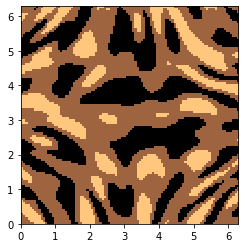

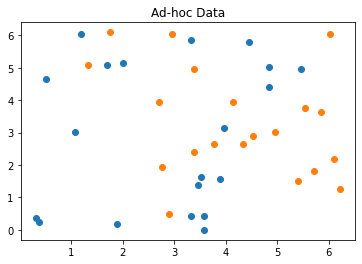

training_input type:  <class 'dict'>
training_input:  {'A': array([[4.83805269, 5.02654825],
       [3.58141563, 0.43982297],
       [4.46106157, 5.78053048],
       [1.69646003, 5.0893801 ],
       [4.83805269, 4.39822972],
       [3.95840674, 3.14159265],
       [3.58141563, 0.        ],
       [0.31415927, 0.37699112],
       [3.33008821, 0.43982297],
       [3.33008821, 5.84336234],
       [3.51858377, 1.63362818],
       [3.45575192, 1.38230077],
       [0.37699112, 0.25132741],
       [1.0681415 , 3.01592895],
       [2.0106193 , 5.15221195],
       [1.19380521, 6.03185789],
       [3.89557489, 1.57079633],
       [1.88495559, 0.18849556],
       [0.50265482, 4.64955713],
       [5.46637122, 4.96371639]]), 'B': array([[1.75929189, 6.09468975],
       [3.39292007, 2.38761042],
       [6.03185789, 6.03185789],
       [6.22035345, 1.25663706],
       [3.39292007, 4.96371639],
       [4.33539786, 2.63893783],
       [3.76991118, 2.63893783],
       [5.84336234, 3.64424748],
       [5

In [21]:
import numpy as np

# Choose which dataset to use
use_breast_cancer_dataset = False

training_size = 20  # Number of samples used for training     
test_size = 10      # Number of samples used for testing
feature_dim = 2     # No. of features in each sample i.e. the dimension of the data
plot_data = True

if use_breast_cancer_dataset:
    sample_Total, training_input, test_input, class_labels = breast_cancer(
        training_size,
        test_size,
        feature_dim,
        plot_data
    )
else:
    gap = 0.3          # "Distance" between samples (influences how difficult it is to separate samples of different class)
    np.random.seed(42) # Seed Numpy's pseudo-random number generator
    sample_Total, training_input, test_input, class_labels = ad_hoc_data(
        training_size, 
        test_size, 
        feature_dim, 
        gap, 
        plot_data
    )
# The above functions return:
#  1. sample_Total is a list (length=n): each element is a list (length=m) containing samples labelled 0 or 1
#     Note: for the breast cancer dataset, n=398, m=2
#           for the ad_hoc_data() function, n=m=100 (hardcoded in the function)
#  2. training_input is a dict. In the example datasets it has two entries:
#           key='A', value=2D numpy array, shape=(training_size,feature_dim)
#           key='B', same as for key='A'
#  3. test_input is a dict. In the example datasets it has two entries:
#           key='A', value=2D numpy array, shape=(test_size,feature_dim)
#           key='B', same as for key='A'
#  4. class_label is a list containing the string labels. In the example datasets they are 'A' and 'B'
    
#print("sample_Total type: ",type(sample_Total))
#print("sample_Total: ", sample_Total)
print("training_input type: ",type(training_input))
print("training_input: ", training_input)
print("test_input type: ",type(test_input))
print("test_input: ", test_input)
#print("class_labels type: ",type(class_labels))
#print("class_labels: ", class_labels)

if not use_breast_cancer_dataset:
    # Sample a small subset so we can detect the labels used in the datasets
#   extra_test_data = sample_ad_hoc_data(sample_Total, 10, n=feature_dim)
    # Above function returns a dictionary. In the example datasets it has two entries:
    #           key='A', value=2D numpy array, shape=(training_size,feature_dim)
    #           key='B', same as for key='A'
    #print("extra_test_data type: ",type(extra_test_data))
    #print("extra_test_data: ", extra_test_data)

    # Reformat the sampled data and obtain a mapping from class name to the numeric label
#    datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
    training_dataset, class_to_label = split_dataset_to_data_and_labels(training_input)
    test_dataset, _ = split_dataset_to_data_and_labels(test_input)
    
    # The above functions return:
    #  1. dataset: a list, where 
    #           element 1 = numpy array of shape (m,n) where m = no. of samples*no_classes, n = dimensionality of the data
    #           element 2 = 1-D numpy array of length m containing the numeric labels of the samples
    #  3. class_to_label: a dictionary. In the example datasets it has two entries:
    #           key='A', value=0
    #           key='B', value=1 
    #print("training_dataset type: ",type(training_dataset))
    #print("training_dataset: ", training_dataset)
    #print("class_to_label type: ",type(class_to_label))
    #print("class_to_label: ", class_to_label)
    print("Mapping from class names to numeric labels:")
    for k, v in class_to_label.items():
        print("\tClass {} -> Label {}".format(k, v))
        
    # The reverse mapping from numeric labels to class names
    label_to_class = {label: class_name for class_name, label
                                   in class_to_label.items()}
    print("Mapping from numeric labels to class names:")
    for k, v in label_to_class.items():
        print("\tLabel {} -> Class {}".format(k, v))
    
    num_classes = len(list(class_to_label.keys()))

### Construct the feature map 

The feature map is typically a non-linear function that maps from the original low dimensional space $\Omega \subset \mathbb{R}^d$, to a high dimensional Hilbert space $\mathcal{H}$ (see Equation 8 above): 
\begin{equation}
\Phi : \Omega \subset \mathbb{R}^d  \rightarrow \mathcal{S}\left(\mathcal{H}_2^{\otimes n}\right)
\end{equation}
where $\mathcal{H}_2 = \mathbb{C}^2$ is the single-qubit Hilbert space and $\mathcal{S}\left(\mathcal{H}_2^{\otimes n}\right)$ is a subset of the full $4^n$ dimensional Hilbert space of $n$ qubits. The density matrix representation of sample $\mathbf{x}$ in the feature space is:
\begin{equation}
\Phi : \mathbf{x}  \rightarrow \ket{\phi(\mathbf{x})} \bra{\phi(\mathbf{x})}.
\end{equation}

In the introduction we showed how we could use a kernel function to fit the separating function in feature space (Equation 10 above):
\begin{equation}
\label{kernel_func}
K\left(\Phi(\mathbf{x}_i, \mathbf{x}_j)\right) = \Phi(\mathbf{x}_i) \cdot \Phi(\mathbf{x}_j).
\end{equation}
If a given dataset cannot be separated using feature maps computed classically, it may be worth considering a quantum approach. To increase our chances of success, we seek feature maps which are hard to estimate classically. To proceed we define a family of feature maps, $\mathcal{U}_{\Phi(\mathbf{x})}$:
\begin{equation}
\label{U_eqn}
\mathcal{U}_{\Phi(\mathbf{x})} = \prod_D U_{\Phi(\mathbf{x})} H^{\otimes n} U_{\Phi(\mathbf{x})} H^{\otimes n}
\end{equation}
consisting of $D$ layers of Hadamard gates ($H$) and entangling blocks:
\begin{equation}
\label{generic_map}
U_{\Phi(\mathbf{x})} = exp \left(i \sum_{S \subseteq [n]} \phi_S(\mathbf{x}) \prod_{k \in S} P_k \right). 
\end{equation}
The feature map for a given sample, $\mathcal{U}_{\Phi(\mathbf{x})}$, is applied to the reference state $\ket{0}^n$. Feature maps of this type can be efficiently implemented using short-depth circuits, thereby enabling the algorithm to be run on quantum devices which are affected by noise (decoherence, dephasing etc.). 

<br>

#### Technical details
In Equation \ref{generic_map} the $P_k$ are gates in the Pauli group:
\begin{equation}
\label{pauli_group}
P_k \in \left\{\mathbb{1}_k, X_k, Y_k, Z_k\right\}
\end{equation}
however any orthonormal operator basis could be used.

***
&#9998; The Pauli group $G_1$ on 1 qubit consists of 16 operators:
$G_1 = \left\{\pm\mathbb{1}, \pm X, \pm Y, \pm Z, \pm i \mathbb{1}, \pm i X, \pm i Y, \pm i Z\right\} = \left\langle X, Y, Z \right\rangle$, where $X$, $Y$ and $Z$ are the Pauli operators. The Pauli group on $n$ qubits, $G_n$, is generated by tensor products of the aforementioned operators.
***
The index $S$ in Equation \ref{generic_map} describes the physical connectivities between the qubits. For $n$ fully connected qubits there are $S \in \left\{\binom{n}{k}, k = 1,... n\right\}$ combinations. For short depth circuits however we only use connections present in the physical device, thereby avoiding any additional operations required to swap qubits.
   
    
    
The function $\phi_S(\mathbf{x})$ is a non-linear classical mapping of the $n$ real coefficients of $\mathbf{x}$ into $2^n$ real coefficients (recall $\mathbf{x} \in \mathbb{R}^n$, where the number of qubits $n$ is equal to the dimension of the sample space, $d$). In this work we use low degree expansions ($\left|S\right| \leqslant d$) so the feature map can be generated using one- and two-qubit gates:
\begin{eqnarray}
\label{U_one_and_two}
U_{\Phi_{\{k\}}}(\mathbf{x}) &=& exp \left(i \phi_{\{k\}}(\mathbf{x}) P_k \right)\\
U_{\Phi_{\{k,l\}}}(\mathbf{x}) &=& exp \left(i \phi_{\{k,l\}}(\mathbf{x}) P_k P_l \right) \nonumber
\end{eqnarray}
where $\phi_S(\mathbf{x})$ has the form:
\begin{equation}
\label{phi_classical}
   \phi_S : \mathbf{x} \mapsto 
   \begin{cases} 
       x_i, & \mbox{if } S = {i}\\
       (\pi - x_i) (\pi - x_j), & \mbox{if } S = {i, j}
   \end{cases}
\end{equation}

***
&#9998; The $\mathcal{U}_{\Phi(\mathbf{x})}$ gate is diagonal in the Pauli Z-basis, which is simply the orthonormal basis formed by two eigenstates of the Pauli Z: $\{\ket{0}, \ket{1}\}$.
***

Qiskit provides tools for constructing generic feature maps. In the code below we illustrate the approach Qiskit uses by manually constructing a feature map consisting of two repetitions of the following circuit:<br>
     ┌──┐┌───────────┐<br>
     ┤ H ├┤ U1(2.0\*x\[0\])├──■────────────────────────────■──<br>
     ├──┤├───────────┤┌─┴─┐┌───────────────────────┐┌─┴─┐<br>
     ┤ H ├┤ U1(2.0\*x\[1\])├┤  X  ├┤ U1(2.0\*(π - x\[0\])\*(π - x\[1\])  ├┤  X  ├<br>
     └──┘└───────────┘└───┘└───────────────────────┘└───┘<br>

qregs contains: [QuantumRegister(2, 'q')]
Steve in simple_product: input array elements have type:  <class 'qiskit.circuit.parameter.Parameter'>
Steve in simple_product: input array elements have type:  <class 'qiskit.circuit.parameter.Parameter'>
Steve in simple_product: input array elements have type:  <class 'qiskit.circuit.parameter.Parameter'>
Steve in simple_product: input array elements have type:  <class 'qiskit.circuit.parameter.Parameter'>


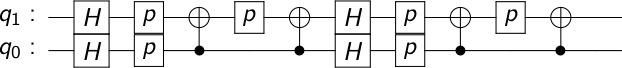

In [24]:
use_qiskit = True
use_qiskit = False
# We can manually contruct the feature map or use the tools in Qiskit
if use_qiskit:
    feature_map = ZZFeatureMap(feature_dim, reps=2)
else:
    # An arbitrary feature map can have various layers, but in our example
    # we only have rotation and entangling layers, and the rotation layer contains a 
    # single Hadamard gate. For details of how to implement layers more generally,
    # see qiskit/circuit/library/n_local/n_local.py. The code below is adapted from 
    # the code in qiskit/circuit/library/n_local/n_local.py and 
    # qiskit/circuit/library/data_preparation/pauli_feature_map.py
    
    paulis = ['Z', 'ZZ'] # List of Pauli operators to apply in the feature map
    reps = 2             # Number of times the set of Pauli operators is repeated in the feature map
    num_qubits = 2       # Number of qubits
    
    # Set the classical mapping function
    # - this function is used to generate the symbolic expression that we wish to evaluate
    # - the input is an array of Parameters (symbolic objects)
    # - the output is a ParameterExpression (the symbolic object resulting from the symbolic expression)
    def simple_product(x: np.ndarray) -> float:
        print("Steve in simple_product: input array elements have type: ", type(x[0]))
        # This implements the classical mapping, φ (see the Equation above)
        coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, np.pi - x)
        return coeff
        
    # Store a reference to the classical map
    data_map_func = simple_product
    
    # Create an empty parameter vector:
    # - a ParameterVector is used for generating lists of parameters. It 
    #   is just a list of Parameters, where each element is a Symbol 
    #   of the form "name[index]" (Parameter's use symbolic maths: see the sympy library)
    # - the label 'x' will be used to refer to a given sample
    ordered_parameters = ParameterVector(name='x', length=feature_dim)
    # → ordered_parameters is essentially a list containing Symbols 'x[0]' and 'x[1]'
    
    # Create an empty parameter table
    # - a Parameter table tracks instructions with variable parameters
    # - it is essentially a dictionary where:
    #   - the keys are Parameters
    #   - the value associated with a given key (i.e. Parameter) is a list of (Instruction, index) tuples,
    #     where "index' is the parameter index at which the parameter appears in the instruction.
    parameter_table = ParameterTable()
    
    # Create a register with the desired number of qubits
    qregs = [QuantumRegister(num_qubits, name='q')]
    print("qregs contains: {}".format(qregs))
    
    # Create the rotation block
    h = HGate()
    circuit = QuantumCircuit(h.num_qubits)
    circuit.append(h, [0])
    rotation_blocks=[circuit]    
    
    # Loop over the number of repetitions in the feature map
    feature_map = QuantumCircuit(*qregs)
    for rep_no in range(reps):     
        ################################
        # Build the rotation layer     #
        ################################
        for block_no, block in enumerate(rotation_blocks):
            # Create an empty circuit
            layer = QuantumCircuit(*qregs)
            
            # The rotation gates are stacked on top of each other.
            #   e.g. if we have 4 qubits and a rotation block of width 2, we apply two instances
            no_of_stacked_blocks = num_qubits // block.num_qubits
            # Determine which qubits are involved in each block in the stack
            # - if there are two stacked blocks and the block has 1 qubit (e.g. a H gate), 
            #   this yields [[0], [1]]
            block_indices = [
                list(range(k * block.num_qubits, (k + 1) * block.num_qubits))
                for k in range(no_of_stacked_blocks)
            ]
            
            # Set the qubits used by the current block e.g. H-gate applied to qubit 1
            for indices in block_indices:
                layer.compose(block, indices, inplace=True)

            # Add the layer to the circuit
            feature_map += layer
            
        ################################
        # Build the entanglement layer #
        ################################
        # 1. Build the entanglement blocks
        #    - this creates a lists of circuits, one circuit for each block 
        #      e.g. a circuit implementing 'Z' and another circuit implementing 'ZZ'
        entanglement_blocks = []
        for pauli_string in paulis:
            # Create a parameter vector
            # - a dummy name is used as this parameter vector is a temporary "placeholder"
            # - the length = number of qubits e.g. 'Z' is a single qubit operator,
            #   while 'ZZ' is a two-qubit operator
            params = ParameterVector('_', length=len(pauli_string))
#WRONG  At run time, the parameters will be passed to the classical map function, φ
#            print("Steve, calling the classical map with args: ", params)
#            print("Steve, calling the classical map with args of type: ", type(params))
#            print("Steve, calling the classical map with arg[0] of type: ", type(params[0]))
            # Construct the ParameterExpression implementing the classical mapping:
            #    φ(x) = x and φ(x,y) = (π - x)(π - y)
            time = data_map_func(np.asarray(params))
            # - this yields: 
            #   1. for a single qubit operation applied to qubit i, where i ∈ [0, 1]:  
            #        time = 2*x[i] (at this stage the name is '_', not 'x')
            #   2. for a two qubit operation:
            #        time = 2*(π - x[0]) * (π - x[1])).
#            print("Steve, called the classical map, got back: ", time)
#            print("Steve, called the classical map, got back type: ", type(time))

            # Get the evolution block for the given pauli string
            # - first, need to reverse the order
            pauli_string = pauli_string[::-1]
            
            # Build a list of the qubit indicies
            indices = []
            for i, _ in enumerate(pauli_string):
                indices += [i]
            
            # Create a quantum circuit with the required number of qubits
            # i.e. one qubit for 'Z', and 2 qubits for 'ZZ'
            evo = QuantumCircuit(len(pauli_string))
            
            # Insert a stack of controlled-X gates
            num_cx = len(indices) - 1
            for i in range(num_cx):
                evo.cx(indices[i], indices[i + 1])
                
            # Apply the U1 rotation, where the argument is the output from the classical map
            # - the argument is a ParameterExpression, for example: '2*(π - x[0]) * (π - x[1]))'
            #   Note: the label 'x' was used in the example above to indicate we are referring to 
            #         components of a given sample 'x', however at this stage the parameter name 
            #         is actually '_' (the mapping to real parameter names is done in Step 2 below).
            # - len(pauli_string)-1 applies the rotation to the last qubit in a multi-qubit 
            #   operation, such as 'ZZ' (this assumes the last Pauli in the string is
            #   not I, for example ZYI)
            qiskit_minor_version = __qiskit_version__['qiskit'].split('.')[1]
            if int(qiskit_minor_version) > 19:
                # U1 was replaced by P
                evo.p(2.0 * time, len(pauli_string)-1)
            else:
                evo.u1(2.0 * time, len(pauli_string)-1)
            
            # Insert a stack of controlled-X gates
            for i in range(num_cx):
                evo.cx(indices[i], indices[i + 1])
                
#            print("Steve, block has params: ", evo.parameters)
#            print("Steve, block params are of type: ", type(evo.parameters))
            entanglement_blocks.append(evo)

        # 2. Set the parameters in each entanglment block and
        #    add them to the relevant qubits in the feature map
        for block_no, block in enumerate(entanglement_blocks):
            # Create an empty circuit
            layer = QuantumCircuit(*qregs)
            
            # Create an "entangling map"
            # - this is a 2D list of qubit indices specifying which qubits are being operated 
            #   on in the current block
            n = num_qubits
            m = block.num_qubits
            # Given the no.of qubits in the circuit (n) is two:
            #  - if the no. of qubits in the current block (m) is 1, this returns [[0], [1]]
            #  - if the no. of qubits in the current block (m) is 2, this returns [[0,1]]
            entangler_map = list(combinations(list(range(n)), m)) 
            
            # Parameterise the current block
            for indices in entangler_map:
                # Use the ParameterVector to generate the indices of the input data:
                # - if the index is 0, the Parameter returned is 'x[0]'' (and similarly 'x[1]'' if the index is 1)
                # - if the indices are 0,1, the Parameters returned are 'x[0]' and 'x[1]'
                # (recall the ParameterVector was created with name='x')
                params = [ordered_parameters[i] for i in indices]
                
                # The block was built with Parameters '_[0]' for a single qubit operator, and 
                # Parameters '_[0]' and '_[1]' for a two qubit operator
                # - pack the parameters of the block with the parameters generated above
                update = dict(zip(block.parameters, params))
                
                # Assign the parameters and return a new block
                # Note: the blocks were created using a "temporary" ParameterVector, which was a placeholder
                #       that enabled us to specify the number of parameters to each block. Here we specify
                #       exactly which parameters are passed. For example, for the single qubit
                #       operator Z, the entanglement block was built with Parameter '_[0]'. In this
                #       loop we apply the Z operator:
                #       - to qubit 0, so the original '_[0]' Parameter is replaced with the 'x[0]' Parameter
                #       - to qubit 1, so the original '_[0]' Parameter is replaced with the 'x[1]' Parameter
                # → this is why the "temporary" ParameterVector was used.
                #   Note: For the two qubit ZZ operator the initial construction with the "temporary"
                #         ParameterVector was not neccessary (it was created with Parameters 
                #         '_[0]' and '_[1]', which are replaced here with Parameters 'x[0]' and 'x[1]'.
                #         In this case it could have been created with the 'x[0]' and 'x[1]'
                #         Parameters directly
                parametrized_block = block.assign_parameters(update)
                
                # Add the current block to the specified qubits in the circuit
                layer.compose(parametrized_block, indices, inplace=True)

            # Add the layer to the circuit
            feature_map += layer

# Draw the feature map circuit
style = {'backgroundcolor': 'lightgreen'}  # Style only works in matplotlib backend
feature_map.draw(output='latex', plot_barriers=True, reverse_bits=True, scale=0.5)
#feature_map.draw(output='mpl', plot_barriers=True, reverse_bits=False, style=style)

### Computing the state overlap
Qiskit provides tools for implementing a quantum-enhanced support vector machine. In the code below we show how to implement the QSVM, following the method used in Qiskit. The circuits constructed below compute the overlap (or inner product) between pairs of samples. To construct and use the SVM, we need to compute the overlap between all unique pairs of samples in the training set (when constructing the kernel matrix), and also between all support vectors and a given test sample (during the classification stage).

The "*swap*" test is commonly used for computing the overlap or *fidelity* between two states, with the overlap given by the expectation value of the SWAP operator:
\begin{equation}
\label{expect_val}
\left<\textrm{SWAP}\right>_{\ket{\phi(\mathbf{x}) \otimes \phi(\mathbf{y})}} = 
\bra{\phi(\mathbf{x}) \otimes \phi(\mathbf{y})} \textrm{SWAP} \ket{\phi(\mathbf{x}) \otimes \phi(\mathbf{y})} = \left| \braket{\phi(\mathbf{x})}{\phi(\mathbf{y})} \right|^2.
\end{equation}
The "*swap*" test is not suitable for use on current devices, so we use the Bell-Basis algorithm proposed by Cincio *et al.*<sup>[1]</sup>. 
The Bell-Basis algorithm is a relatively short-depth circuit (the number of gates scales linearly with the number of qubits) and therefore likely to yield better results on noisy devices. To understand the algorithm, first consider the single cubit case, for which the circuit is:

<div>
<img src="bell_basis_algorithm_for_SWAP_test_single_qubit.png">
</div>

(see Figure 6a in Cincio *et al.*). The overlap is given by:
\begin{equation}
\label{post_proc}
\sum_i c_i \,p_i
\end{equation}
where $\mathbf{c} = \left(1, 1 ,1, -1\right)$ and the $p_i$ are measurement probabilities for the $00$, $01$, $10$ and $11$ outcomes. 
***
&#9998; Consider the measurement of an arbitrary single qubit state, $\ket{\psi}$. When measuring in $Z$, we have (projective) measurement operators:
\begin{eqnarray}
\label{measure_ops}
P_0 &=& \ket{0}\!\bra{0} \\
P_1 &=& \ket{1}\!\bra{1} \nonumber
\end{eqnarray} 
and the corresponding probabilities of the measurement outcomes are:
\begin{eqnarray}
\label{measure_probs}
p(m\!=\!0) &=& \bra{\psi} P_0 \ket{\psi} = \braket{\psi}{0}\braket{0}{\psi} = \left| \braket{\psi}{0} \right |^2 \\
P(m\!=\!1) &=& \bra{\psi} P_1 \ket{\psi} = \braket{\psi}{1}\braket{1}{\psi} = \left| \braket{\psi}{1} \right |^2 \nonumber .
\end{eqnarray}
In general, the probability of measuring $n$ qubits in $Z$ and obtaining bit string $\ket{x_1 \ldots x_n}$ is $\left| \braket{x_1 \ldots x_n}{\psi} \right |^2$. Applying the post-processing step in the Bell-Basis algorithm (Equation \ref{post_proc}) to an arbitrary 2-qubit state $\ket{\psi \otimes \phi}$ yields:
\begin{eqnarray}
\label{post_proc_v2}
\sum\nolimits_i c_i \,p_i &=& 1 \times \left| \braket{00}{\psi \otimes \phi} \right | ^2 \\
                          &+& 1 \times \left| \braket{01}{\psi \otimes \phi} \right | ^2 \nonumber \\
                          &+& 1 \times \left| \braket{10}{\psi \otimes \phi} \right | ^2 \nonumber \\
                          &-& 1 \times \left| \braket{11}{\psi \otimes \phi} \right | ^2 \nonumber .
\end{eqnarray}
If we recall CZ has eigenvalues $\lambda_i = \left(1, 1 ,1, -1\right)$ and eigenvectors $\Psi_i = \ket{00}, \ket{01}, \ket{10}$ and $\ket{11}$, we see the post-processing step (Equation \ref{post_proc_v2}) yields the expectation value of the controlled-Z operator, expressed using its spectral decomposition:
\begin{equation}
\label{expect_val_CtrlZ}
\left<\textrm{CZ}\right>_{\ket{\psi \otimes \phi}} = 
\bra{\psi \otimes \phi} \textrm{CZ} \ket{\psi \otimes \phi)} =
\sum_i \lambda_i \left| \braket{\Psi_i}{\psi \otimes \phi} \right| ^2.
\end{equation}

In this case, measurement of the original state $\ket{\psi \otimes \phi}$ yielded the expectation value of the CZ operator. However, we seek the state overlap which is given by the expectation value of the SWAP operator. To proceed we note that the circuit in the Bell-Basis algorithm consists of a CNOT and Hadamard gate, so the state being measured is:
\begin{equation}
\label{define_new_state}
\ket{\Phi} = \left( H \otimes I \right) . CNOT_{1 \rightarrow 2} . \ket{\psi \otimes \phi}.
\end{equation}
With a suitable number of shots we can estimate the measurement probabilities 
$\left| \braket{00}{\Phi_i} \right| ^2, \left| \braket{01}{\Phi_i} \right| ^2$ *etc.*, and the post-processing step now yields:
\begin{eqnarray}
\label{post_proc_v3}
\sum\nolimits_i c_i \,p_i &=& 1 \times \left| \braket{00}{\Phi} \right | ^2 \\
                          &+& 1 \times \left| \braket{01}{\Phi} \right | ^2 \nonumber \\
                          &+& 1 \times \left| \braket{10}{\Phi} \right | ^2 \nonumber \\
                          &-& 1 \times \left| \braket{11}{\Phi} \right | ^2 \nonumber
\end{eqnarray}
which is the desired expectation value of the SWAP operator for the the state $\ket{\psi \otimes \phi}$ *i.e.* $\left<\textrm{SWAP}\right>_{\ket{\psi \otimes \phi}}$. Note: $\ket{01}$ and $\ket{10}$ are not eigenvectors of the SWAP operator, so Equation \ref{post_proc_v3} is not a spectal decomposition (whereas Equation \ref{post_proc_v2} is). 
***
The circuit implementing Cincio *et al.*'s algorithm for computing the overlap between two $n$-qubit states $\ket{\phi(\mathbf{x})}$ and $\ket{\phi(\mathbf{y})}$ is: 
<div>
<img src="bell_basis_algorithm_for_SWAP_test.png">
</div>

The circuit appears to be relatively deep and therefore unlikely to yield usable results on noisy hardware. However, the algorithm is efficient because:<br>
1. the CNOT and Hadamard gates for each pair of qubits (see the single qubit circuit above) can be executed in parallel; and<br>
2. the expectation value of the $n$-qubit system can be obtained from the expectation values of the two-qubit pairs.<br>

To understand how the multiqubit SWAP gate works, we:<br>
1. decompose the multiqubit SWAP gate into a product of two-qubit swap gates:
\begin{equation}
\textrm{SWAP} = \prod_{k=1}^n \textrm{SWAP}_{s_kt_k},
\end{equation}
2. diagonalize each two-qubit SWAP using $CNOT_{i\rightarrow j} H_i$ (see the single qubit circuit above)<br>
3. measure each two-qubit pair, obtaining the eigenvalue $(-1)^{s_it_i}$<br>
4. combine the results for all the two-qubit pairs:
\begin{equation}
f(s,t) = (-1)^{s_1t_1 + \ldots + s_nt_n}
\end{equation}
Averaging the result over many shots yields the desired overlap.
<br><br>

***
### *Is this correct?*
<br>
Diagonalizing the full $n$-qubit SWAP operator enables us to estimate the desired overlap because:
\begin{equation}
\left< D \right>_{\phi,\psi} = \prod_{i=1}^n \left< D_i \right>_{\phi_i,\psi_i}
\end{equation}
for diagonal operators $D$ and $D_i$ where $D = \prod_{k=1}^n D_i$ and states $\ket{\phi} = \ket{\phi_1 \otimes \phi_2 \otimes \ldots \otimes \phi_n}$ and $\ket{\psi} = \ket{\psi_1 \otimes \psi_2 \otimes \ldots \otimes \psi_n}$. In other words, the expectation value of the $n$-qubit system is the product of the expectation values of the two-qubit pairs.
<br>

### *I can't see how this works for entangled states*

***

The method described above can be used to compute the overlap between arbitrary input states $\ket{\psi}$ and $\ket{\phi}$. In our application however, the overlap can be computed more easily because the input states are structured by design. Recall our input states were created by applying the feature map $\mathcal{U}_{\Phi(\mathbf{x})}$ (see Equation 4 above) to the reference state $\ket{0^n}$. The desired overlap:
\begin{eqnarray}
\left| \braket{\phi(\mathbf{x})}{\phi(\mathbf{y})} \right|^2 &=&
\left| \bra{0^n} \mathcal{U}_{\Phi(\mathbf{x})}^{\dagger} \mathcal{U}_{\Phi(\mathbf{x})} \ket{0^n} \right|^2 \\
&=&\left| \braket{0^n}{\mathcal{U}_{\Phi(\mathbf{x})}^{\dagger} \mathcal{U}_{\Phi(\mathbf{x})} 0^n} \right|^2 \nonumber
\end{eqnarray}
which is simply the probability of measuring bit string $\ket{0^n}$ on state $\mathcal{U}_{\Phi(\mathbf{x})}^{\dagger} \mathcal{U}_{\Phi(\mathbf{x})}\ket{0^n}$. The probability (and therefore the overlap) can be estimated by preparing multiple copies of the state $\mathcal{U}_{\Phi(\mathbf{x})}^{\dagger} \mathcal{U}_{\Phi(\mathbf{x})}\ket{0^n}$ and measuring each one in the computational basis. The overlap is given by the fraction of samples for which the $0^n$ bit string was observed.
<br>

### *Does this only work for diagonal operators?*

<br><br>
<sup>[1]</sup> Lukasz Cincio, Yiğit Subaşı, Andrew T. Sornborger, Patrick J. Coles. "Learning the quantum algorithm for state overlap", New J. Phys. 20, 113022 (2018) DOI: [10.1088/1367-2630/aae94a](https://arxiv.org/ct?url=https%3A%2F%2Fdx.doi.org%2F10.1088%2F1367-2630%2Faae94a&v=eb9c4c5d). An online copy is available [here](https://arxiv.org/abs/1803.04114).

Using 1024 shots
Circuit after being transpiled has type: <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


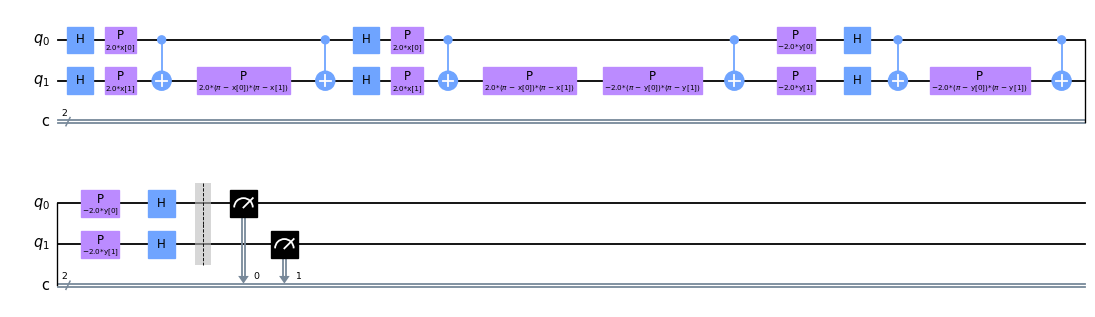

Complete circuits for computing the overlap:
Complete circuit has type:  <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


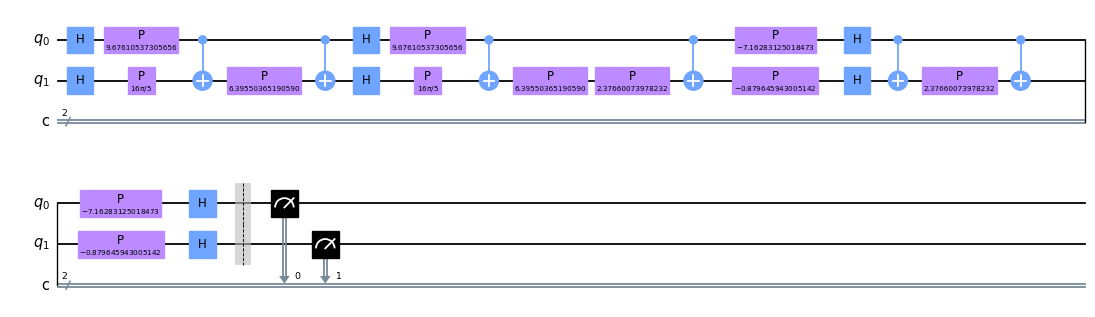

Complete circuits for computing the overlap:
Complete circuit has type:  <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


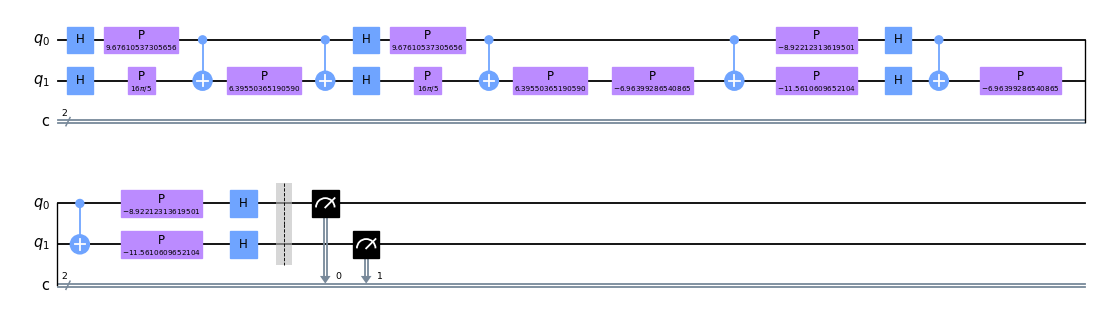

Complete circuits for computing the overlap:
Complete circuit has type:  <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


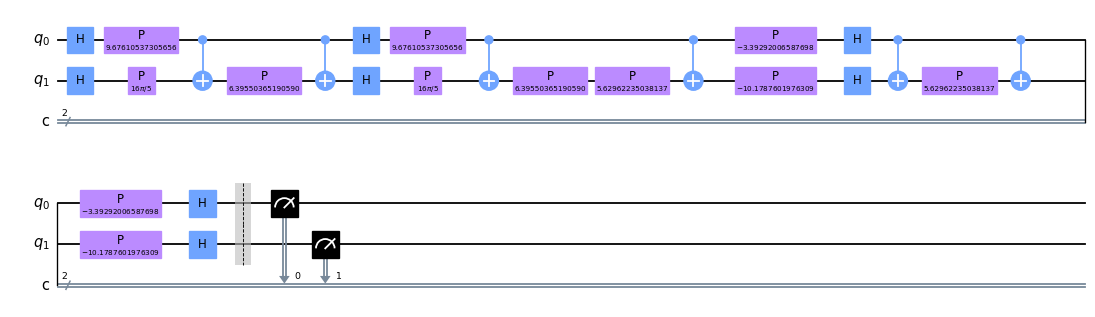

Kernel matrix during the training:


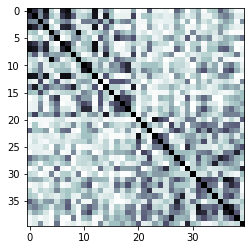

In [29]:
random_seed = 10598
np.random.seed(random_seed)

use_qiskit = True
use_qiskit = False
# We can manually contruct the feature map or use the tools in Qiskit
if use_qiskit:
    qsvm = QSVM(feature_map, training_input, test_input, None)
    qsvm.random_seed = random_seed
else:
    no_shots = 1024
    print("Using {} shots".format(no_shots))
    quantum_instance = QuantumInstance(backend, shots=no_shots, seed_simulator=random_seed,
                                       seed_transpiler=random_seed)

    qregs = [QuantumRegister(num_qubits, name='q')]
        
    # Create parameter vectors for later use
    feature_map.feature_dimension = len(feature_map.parameters)
    #feature_map_params_x = ParameterVector('x', feature_map.feature_dimension)
    #feature_map_params_y = ParameterVector('y', feature_map.feature_dimension)
    #print("feature map type: ", type(feature_map))
    #print(feature_map)

    # Get the training samples: data are at index 0, labels are at index 1
    data = training_dataset[0]
    
    # Measurement will be done in the z-axis
    measurement_basis = '0' * feature_map.num_qubits
    
    ###############################
    # Construct the kernel matrix #
    ###############################
    # - with the feature map defined above, the kernel matrix is symmetric
    # - the matrix element i,j is the overlap between the mapped samples i and j
    no_training_samples = len(data)
    kernel_matrix = np.ones((no_training_samples, no_training_samples))
    
    # Get the indices of the upper triangle of the matrix (offset k=1 skips the diagonal)
    mus, nus = np.triu_indices(no_training_samples, k=1)
    
    # The matrix is computed in blocks (this may be useful if the no. of samples is large)
    BATCH_SIZE = 1000
    for idx in range(0, len(mus), BATCH_SIZE):
        to_be_computed_data_pair = []
        to_be_computed_index = []
        # Construct a list containing pairs of indices: the overlap will be computed
        # between the two samples defined by the indices in each pair 
        for sub_idx in range(idx, min(idx + BATCH_SIZE, len(mus))):
            #print("Constructing circuit for overlap pair {}/{}".format(sub_idx, len(mus)))
            i = mus[sub_idx] # Row index
            j = nus[sub_idx] # Column index
            x1 = data[i]
            x2 = data[j]
            # If the two samples are not identical, add them to the list of sample pairs
            # (the overlap will be computed for each pair or samples in the list)
            if not np.all(x1 == x2):
                to_be_computed_data_pair.append((x1, x2))
                to_be_computed_index.append((i, j))
                
        
#print("Steve, feature_map.feature_dimension: ", feature_map.feature_dimension)
        # The parameter vectors contain: ['x[0]', 'x[1]'] and ['y[0]', 'y[1]'] 
        feature_map_params_x = ParameterVector('x', feature_map.feature_dimension)
        feature_map_params_y = ParameterVector('y', feature_map.feature_dimension)
        
        # Construct a parameterised circuit to compute the overlap
        q = QuantumRegister(feature_map.num_qubits, 'q')
        c = ClassicalRegister(feature_map.num_qubits, 'c')
        parameterised_circuit = QuantumCircuit(q, c)
            
        # Circuit to map sample x1 to φ(x1)
        param_dict = dict(zip(ordered_parameters, feature_map_params_x))
        psi_x1 = feature_map.assign_parameters(param_dict)
        parameterised_circuit.append(psi_x1.to_instruction(), parameterised_circuit.qubits)
        
    #print("Circuit containing psi_x1:")
    #show_figure(parameterised_circuit.draw(output='mpl', plot_barriers=True, reverse_bits=False, scale=0.9))
            
        # Circuit to map sample x2 to φ(x2)
        param_dict = dict(zip(ordered_parameters, feature_map_params_y))
        psi_x2_dag = feature_map.assign_parameters(param_dict)
        parameterised_circuit.append(psi_x2_dag.to_instruction().inverse(), parameterised_circuit.qubits)
        
    #print("Circuit containing psi_x1 and psi_x2_dag:")
    #show_figure(parameterised_circuit.draw(output='mpl', plot_barriers=True, reverse_bits=False, scale=0.9))
        
        #if idx == 0:
            #print("Circuit psi_x1:")
        #print("Circuit psi_x1 type:", type(parameterised_circuit[-1]))
        #print("Circuit psi_x1:", parameterised_circuit[-1])
        #tmp = psi_x1.to_instruction()
        #print("Circuit psi_x1 after converting to instruction, type:", type(tmp))
        #print("Circuit psi_x1 after converting to instruction, :", tmp)
            
          #  parameterised_circuit[-1].draw(output='latex', plot_barriers=True, reverse_bits=False, scale=0.5)
            #print("Circuit psi_x2_dag:")
           # parameterised_circuit[-2].draw(output='latex', plot_barriers=True, reverse_bits=False, scale=0.5)
            
        # Measure in the z-basis
        parameterised_circuit.barrier(q)
        parameterised_circuit.measure(q, c)
        
    #    if idx == 0:
     #       print("Circuit before being transpiled has type:", type(parameterised_circuit))
            #print("Circuit before being transpiled:", parameterised_circuit)
            #parameterised_circuit.draw(output='latex', plot_barriers=True, reverse_bits=False, scale=0.5)
            
        # Transpile the parameterised circuit
        # - the alternative approach (apply parameters first and then transpiling multiple circuits)
        #   is less efficient
        parameterised_circuit = quantum_instance.transpile(parameterised_circuit)[0]
        
        #if idx == 0:
        print("Circuit after being transpiled has type:", type(parameterised_circuit))
            #print("Circuit after being transpiled:", parameterised_circuit)
        show_figure(parameterised_circuit.draw(output='mpl', plot_barriers=True, reverse_bits=False, scale=0.9))
            
        # For each pair of samples for which we need to compute the overlap (i.e. entry in
        # the kernel matrix), we create a circuit. This is done by assigning values to the parameters:
        # - up to this point we have had a single parameterised_circuit. The lambda function 
        #   creates a set of circuits; one circuit for each pair of samples between which 
        #   the overlap is to be computed. Each circuit is obtained by replacing the parameters 
        #   with the coefficients from the respective samples.
        circuits = [
            # To create a circuit for a given pair of samples, pass two dict's, each consisting of 
            # a parameter vector and the values that will be substituted for the parameters
            parameterised_circuit.assign_parameters({feature_map_params_x: x, feature_map_params_y: y})
               for x, y in to_be_computed_data_pair
        ]
        # Print out some of the circuits
        if idx == 0:
            for c_idx in range(3):
                print("Complete circuits for computing the overlap:")
                print("Complete circuit has type: ", type(circuits[c_idx]))
                #print("Circuit: ", circuits[c_idx])
                show_figure(circuits[c_idx].draw(output='mpl', plot_barriers=True, reverse_bits=False, scale=0.9))

        # Execute the circuits
        results = quantum_instance.execute(circuits, had_transpiled=True)
        
        # For each circuit, convert the count into the overlap
        # - if there are a lot of circuits it may be more efficient to do this task in parallel
        # (Qiskit has tools for doing tasks in parallel)
        matrix_elements = []
        for circuit_idx in range(len(circuits)):
            circuit_result = results.get_counts(circuit_idx)
            kernel_value = circuit_result.get(measurement_basis, 0) / sum(circuit_result.values())
            matrix_elements.append(kernel_value)
            
        # Insert the values into the kernel matrix
        for (i, j), value in zip(to_be_computed_index, matrix_elements):
            kernel_matrix[i, j] = kernel_matrix[j, i] = value
                      
    # Display the matrix
    print("Kernel matrix during the training:")
    if True:
        # Display the matrix as an image
        img = plt.imshow(kernel_matrix,interpolation='nearest',origin='upper',cmap='bone_r')
        plt.show()
    else:
        # Output the individual matrix elements
        for row in range(no_training_samples):
            for col in range(row, no_training_samples):
                print("Kernel element row={:4d}, col={:4d}: {:10.7f}".format(
                    row, col, kernel_matrix[row, col]))

### Construct the Support Vector Machine

In the preceding sections we showed how to construct the circuits for:
1. implementing the feature map, and
2. computing the state overlap.


The finish our tutorial, we need to:
1. construct the SVM (using a standard classical algorithm to find the optimal support vectors)
2. evaluate the SVM using samples in the training dataset
3. use the SVM to classify samples in the test datasets

In the cell below, we use the optimizer to compute the support vectors and the associated weights.

In [32]:
from qiskit.aqua.utils import optimize_svm

# L2 norm regularization factor
lambda2 = 0.001

# Get the labels for the training samples
labels = training_dataset[1]   # numpy 1-D array of numeric labels (0 or 1), corresponding to each sample
    
# Map the labels 0 --> -1 and 1 --> 1, and convert to floats
labels = labels * 2 - 1  # map label from 0 --> -1 and 1 --> 1
labels = labels.astype(float)

print("labels are: ", labels)
print("kernel matrix is: ", kernel_matrix)

# Identify the optimal support vectors and return the weights (alpha) and bias (b)
[alpha, b, support] = optimize_svm(kernel_matrix, labels, scaling=None, lambda2=lambda2)
support_index = np.where(support)
alphas = alpha[support_index]
svms = data[support_index]
yin = labels[support_index]

for index in support_index:
    print("Support vector (sample {:d}) has weight: {:.6f} and label {:d}".format(
        index, int(labels[index]), alpha[index]))
print("Bias: {:.6f}".format(b))

labels are:  [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]
kernel matrix is:  [[1.         0.79785156 0.46386719 ... 0.14941406 0.02832031 0.04199219]
 [0.79785156 1.         0.43457031 ... 0.34277344 0.08984375 0.08984375]
 [0.46386719 0.43457031 1.         ... 0.26171875 0.03125    0.42285156]
 ...
 [0.14941406 0.34277344 0.26171875 ... 1.         0.61816406 0.11523438]
 [0.02832031 0.08984375 0.03125    ... 0.61816406 1.         0.16015625]
 [0.04199219 0.08984375 0.42285156 ... 0.11523438 0.16015625 1.        ]]


DQCPError: The problem is not DQCP.

### Run the algorithm

With the dataset ready and circuits constructed we can now run the algorithm.

For the testing, the result includes the details and the success ratio.

For the prediction, the result includes the predicted labels. 

In [34]:
# We use Qiskit's help functions in the QSVM class
from qiskit.aqua.algorithms import QSVM
svm = QSVM(feature_map, training_input, test_input, None) # the data for prediction can be fed later.
svm.random_seed = random_seed

print("The manually constructed quantum_instance is: ", quantum_instance)
print("================== END =================")
quit

# Fit the classifier
result = svm.run(quantum_instance)


# Display the kernel matrix constructed from the training dataset
print("Kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

# Output the accuracy of the classifier when classifying the training dataset
print("testing success ratio: {}".format(result['testing_accuracy']))

# Use the classifier on the (unseen) testing dataset
print("Prediction of (unseen) test datapoints:")
predicted_labels = qsvm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, qsvm.label_to_class)
print("ground truth: {}".format(datapoints[1]))
print("prediction:   {}".format(predicted_labels))

Steve in  QSVM.__init__()
Steve in  QSVM.setup_training_data()
Steve in  QSVM.setup_test_data()
Steve in  QSVM.setup_datapoint()
Steve in  _QSVM_ABC.__init__()
The manually constructed quantum_instance is:  
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
================== END =================
Steve in  QSVM._run()
Steve in  _QSVM_Binary.run()
Steve in  _QSVM_Binary.train()
Steve in  QSVM.construct_kernel_matrix()
Steve in  QSVM.get_kernel_ma

CircuitError: "Name conflict applying operation for parameters: {'x[0]'}"

### Run the algorithm on the breast cancer dataset
Now we run our algorithm with the real-world dataset: the breast cancer dataset, we use the first two principal components as features.

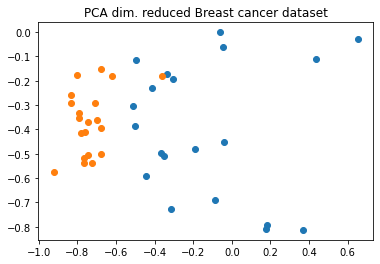

NameError: name 'qsvm' is not defined

In [30]:
sample_Total, training_input, test_input, class_labels = breast_cancer(
    training_size=20,
    test_size=10,
    n=2,
    plot_data=True
)

#feature_map = ZZFeatureMap(feature_dim, reps=2)
#qsvm = QSVM(feature_map, training_input, test_input, None)# the data for prediction can be fed later.
qsvm.random_seed = random_seed
#quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=random_seed, seed_transpiler=random_seed)
result = qsvm.run(quantum_instance)

"""declarative approach, re-use the params above
algo_input = ClassificationInput(training_input, test_input)
result = run_algorithm(params, algo_input)
"""

print("testing success ratio: {}".format(result['testing_accuracy']))

print("prediction of datapoints:")
predicted_labels = qsvm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, qsvm.label_to_class)
print("ground truth: {}".format(datapoints[1]))
print("prediction:   {}".format(predicted_labels))

In [ ]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()